In [336]:
!pip install pmdarima

In [337]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [338]:
df = pd.read_csv("airline-passengers.csv")
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


## EDA

In [339]:
df.shape

(144, 2)

In [340]:
#Checking the data types
df.dtypes

Month         object
Passengers     int64
dtype: object

In [341]:
df.isna().any()

Month         False
Passengers    False
dtype: bool

In [342]:
df.isna().sum()

Month         0
Passengers    0
dtype: int64

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [344]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


## Feature Engineering

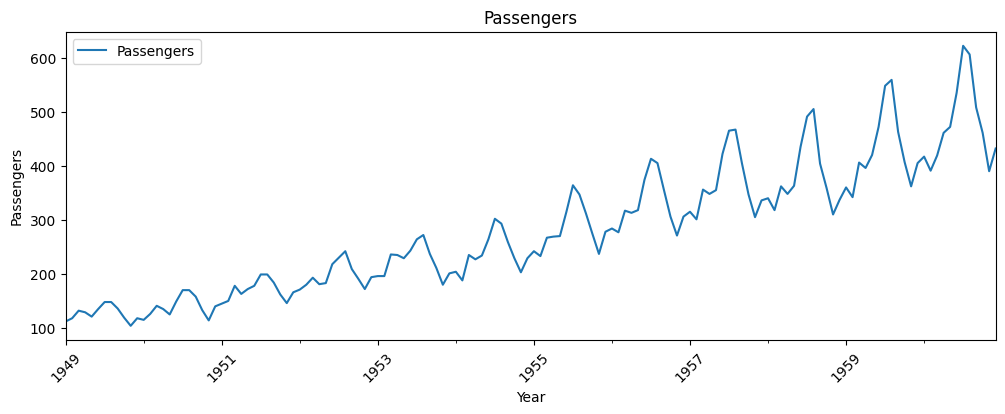

In [345]:
# Set 'Date' column as index
df.rename(columns = {'Month' : 'Date'}, inplace = True)
df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(0)

df1 = df.copy()
df1.set_index('Date',inplace=True)
df1.index.year

# Plotting
df1.plot(figsize=(12,4))
plt.xlabel('Year')  # Setting X-axis label
plt.ylabel('Passengers')  # Setting Y-axis label
plt.xticks(rotation = 45)
plt.title('Passengers')  # Setting plot title
plt.show()

In [346]:
df["Month"] = df.Date.dt.strftime("%b") # month extraction
df["Year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

,Date,Passengers,Month,Year
0,1949-01-31,112,Jan,1949
1,1949-02-28,118,Feb,1949
2,1949-03-31,132,Mar,1949
3,1949-04-30,129,Apr,1949
4,1949-05-31,121,May,1949
5,1949-06-30,135,Jun,1949
6,1949-07-31,148,Jul,1949
7,1949-08-31,148,Aug,1949
8,1949-09-30,136,Sep,1949
9,1949-10-31,119,Oct,1949


## Data Visualization

<Axes: xlabel='Month', ylabel='Year'>

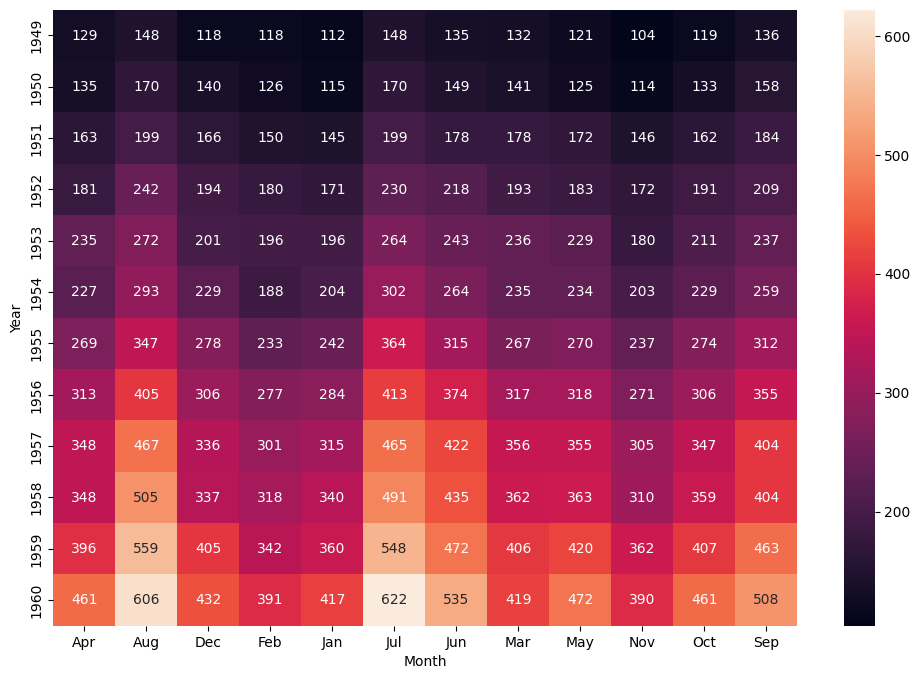

In [347]:
# Heatmap
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=df, values="Passengers",index="Year",columns="Month",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

### Histogram and Density plot

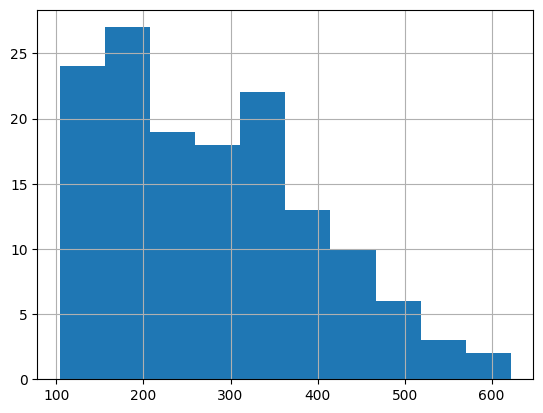

In [348]:
df['Passengers'].hist()
pyplot.show()

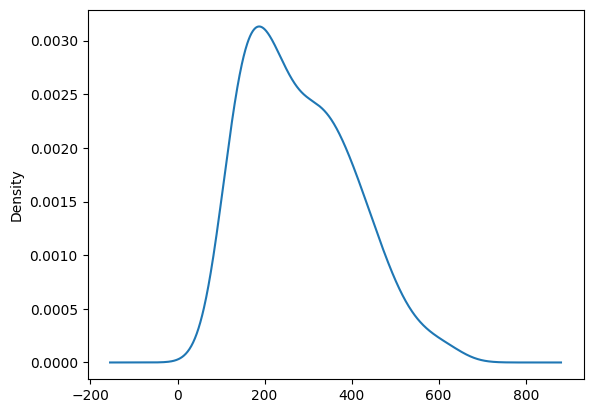

In [349]:
df['Passengers'].plot(kind='kde')
pyplot.show()

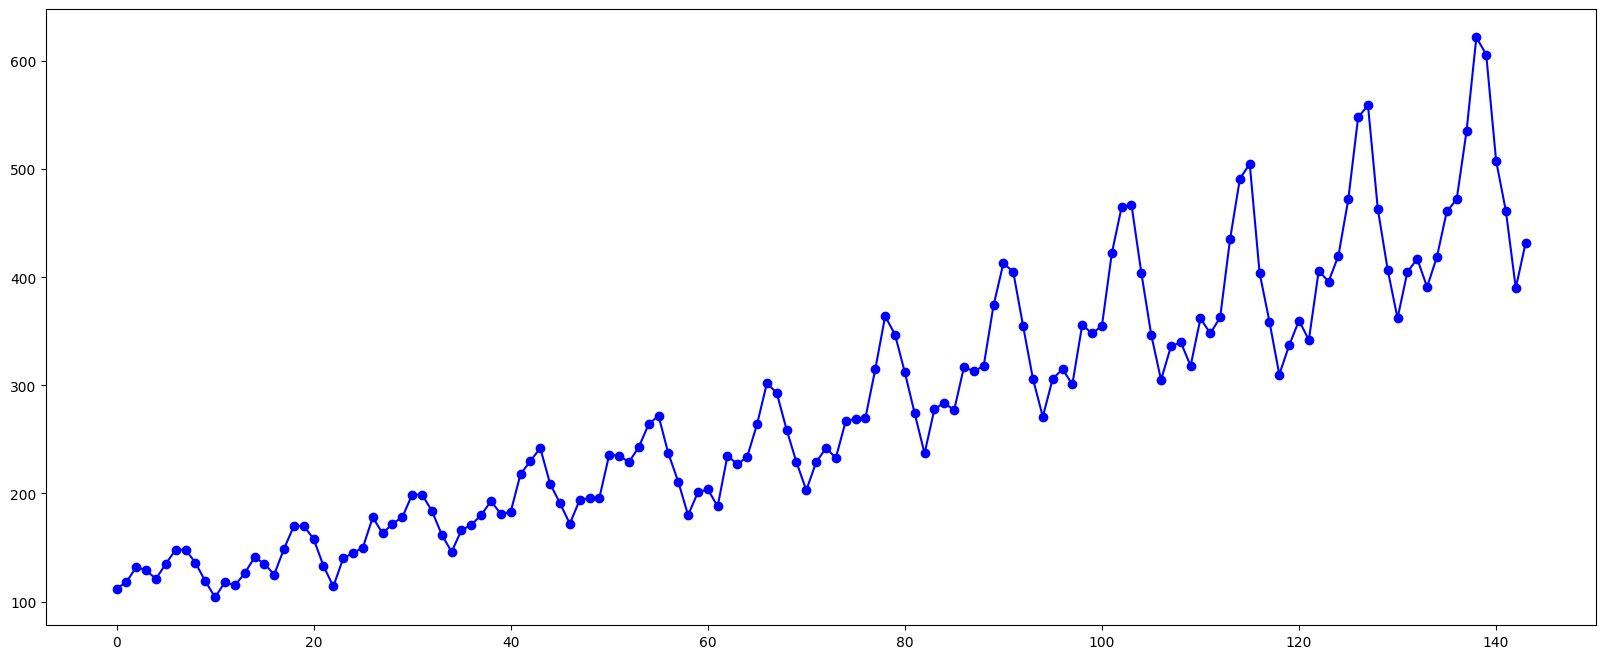

In [350]:
df['Passengers'].plot(figsize=(20, 8),color='blue',marker='o')
plt.show()

<Axes: xlabel='Month', ylabel='Passengers'>

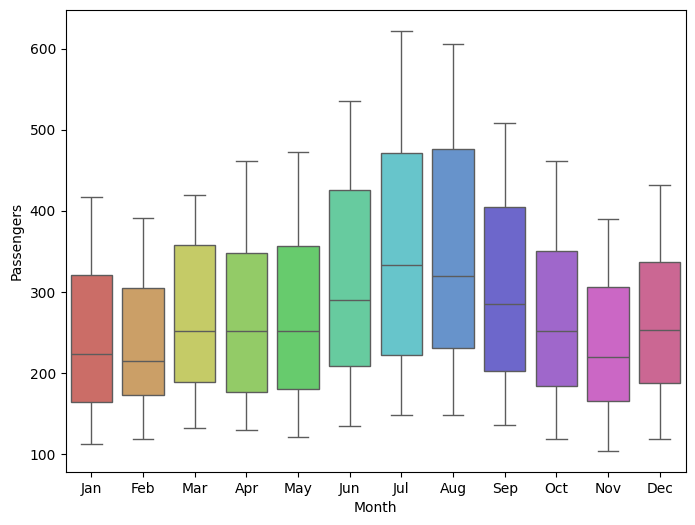

In [351]:
# Boxplot for month-wise
plt.figure(figsize=(8,6))
sns.boxplot(x="Month",y="Passengers",data=df, palette = 'hls')

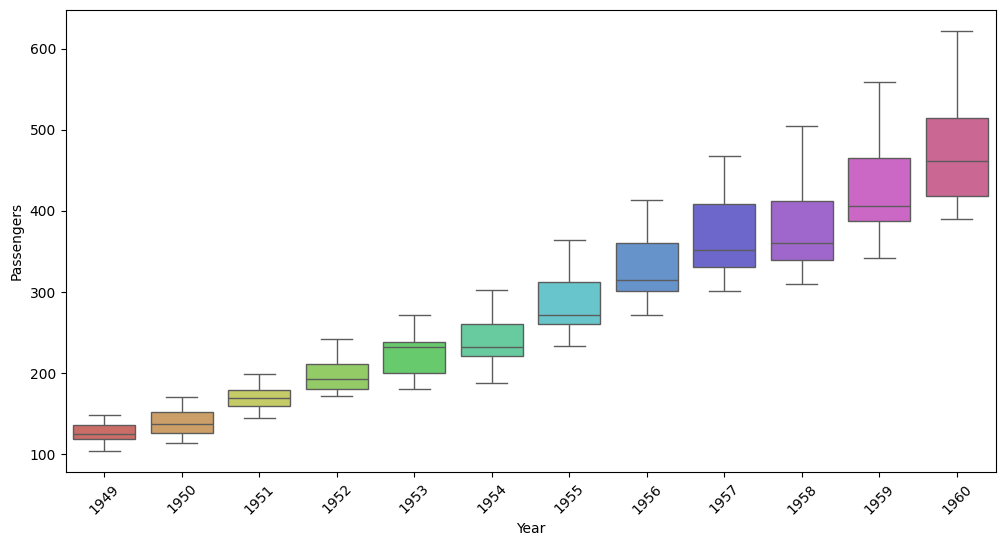

In [352]:
# Boxplot for year-wise
plt.figure(figsize=(12,6))
sns.boxplot(x="Year",y="Passengers",data=df, palette = 'hls')
plt.xticks(rotation = 45)
plt.show()

##### **Observation** : We can see that there are no outliers in our data

### Line Plot

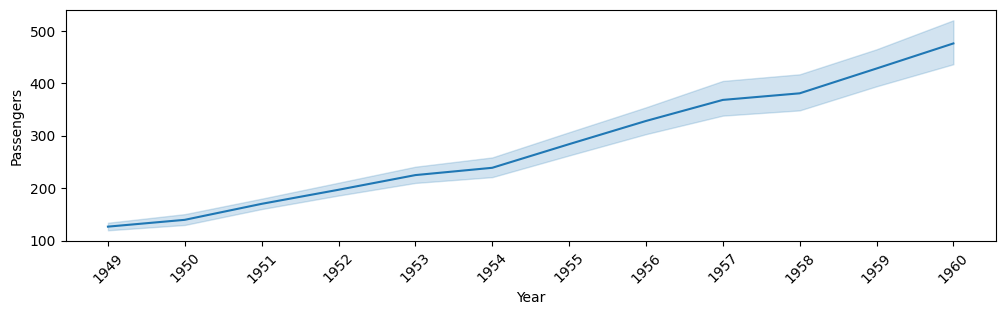

In [353]:
plt.figure(figsize=(12,3))
sns.lineplot(x="Year",y="Passengers",data = df)
plt.xticks(rotation = 45)
plt.show()

### Lag plot

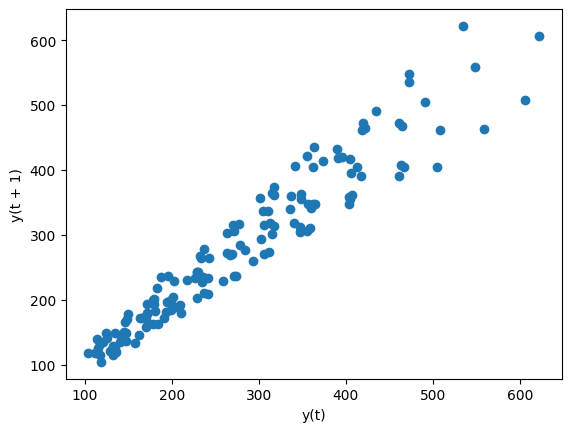

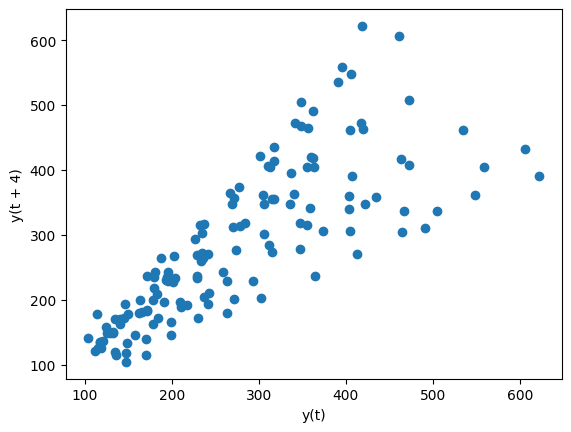

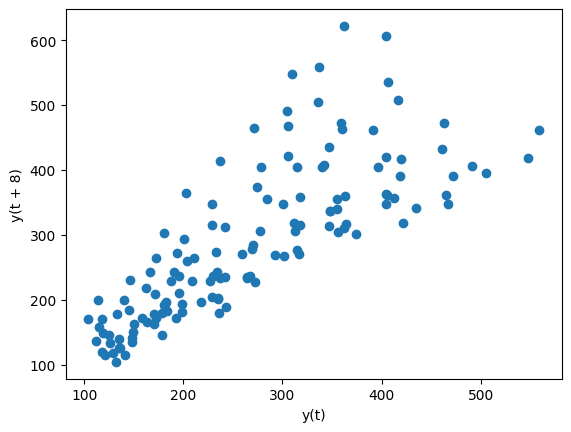

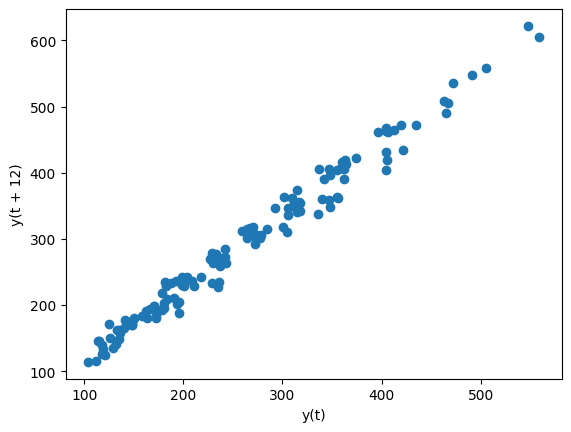

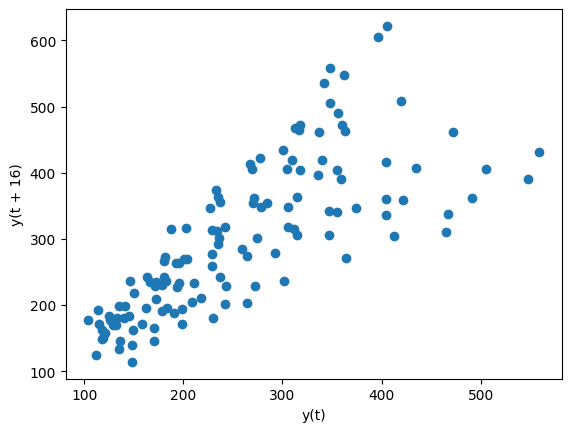

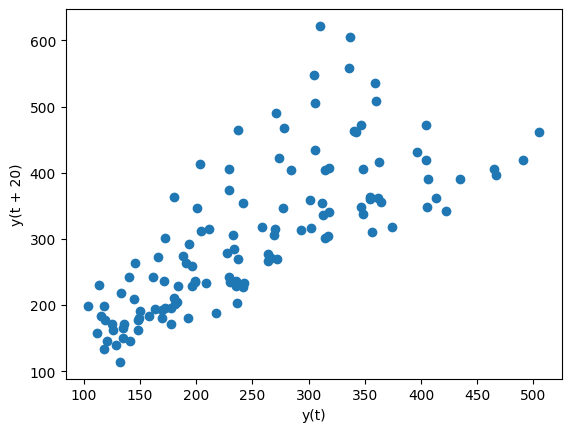

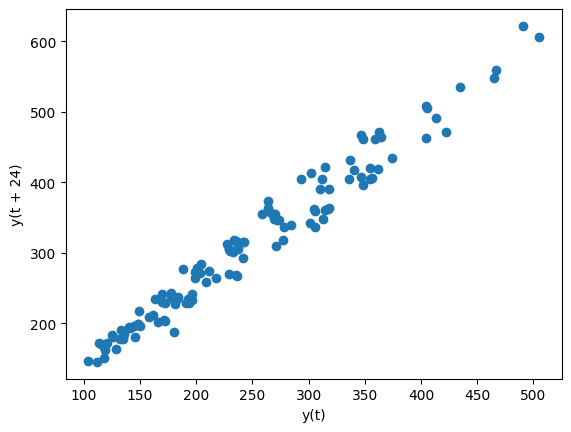

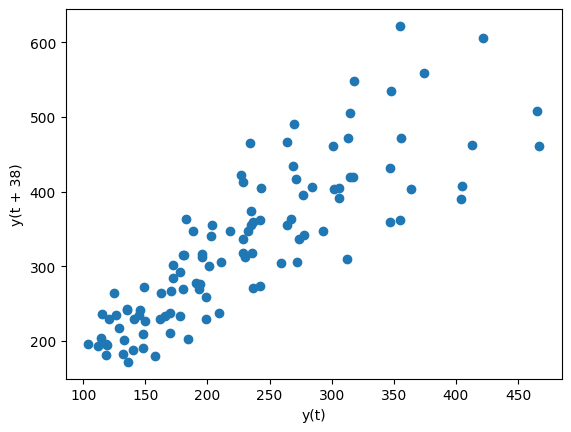

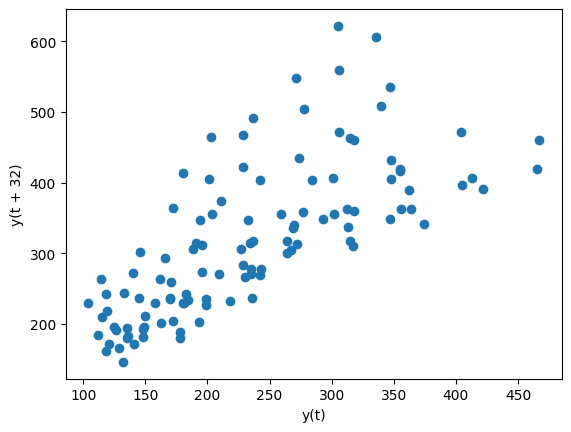

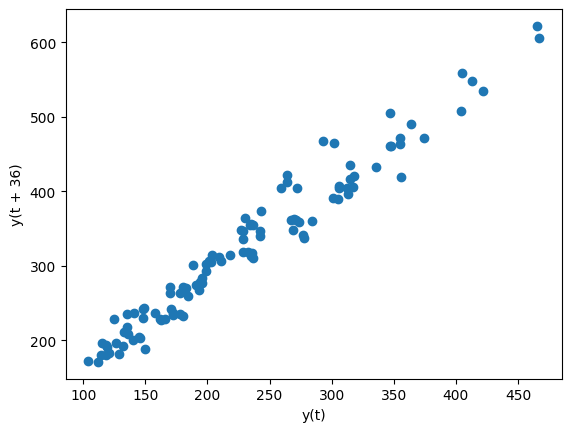

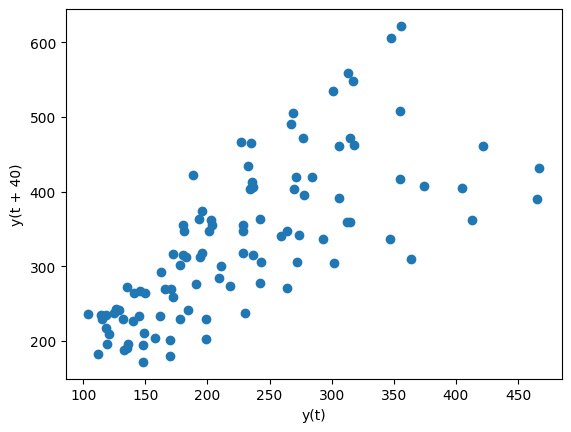

In [354]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Passengers, lag=i)
    plt.show()

## Moving Average

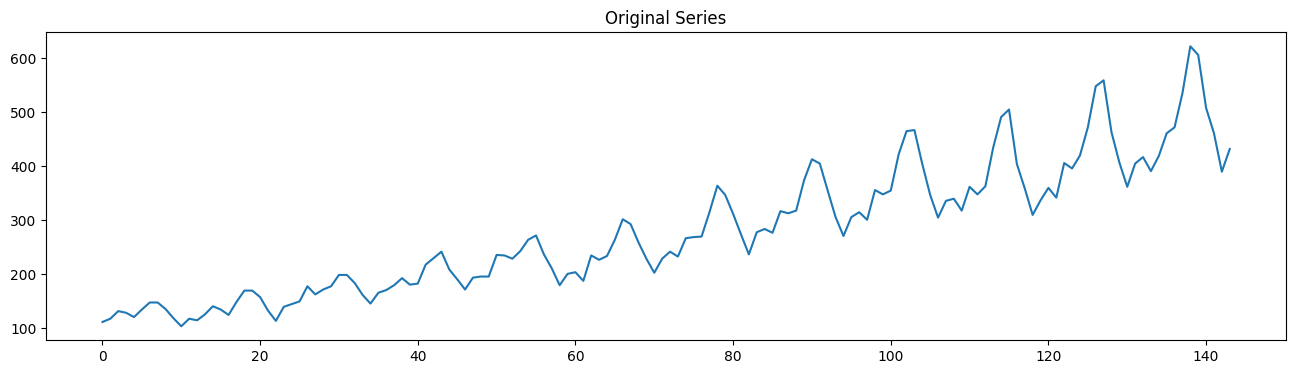

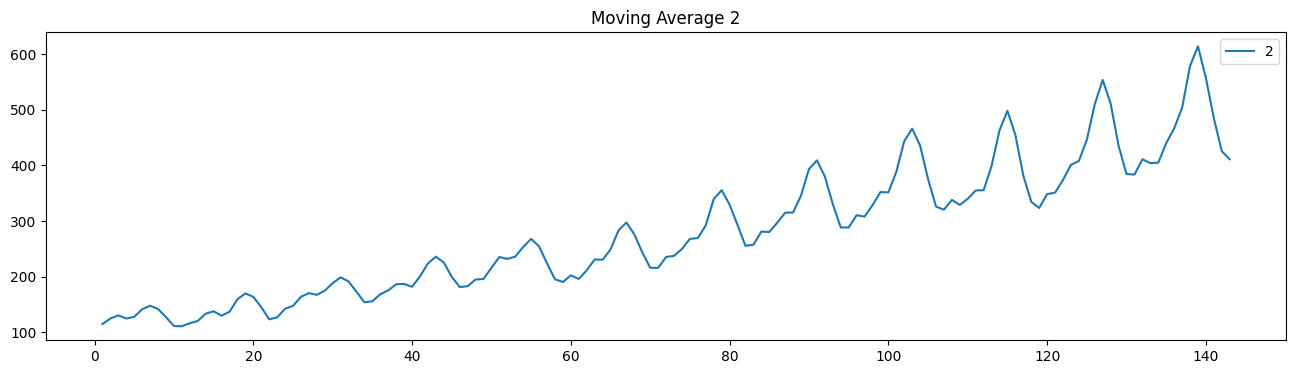

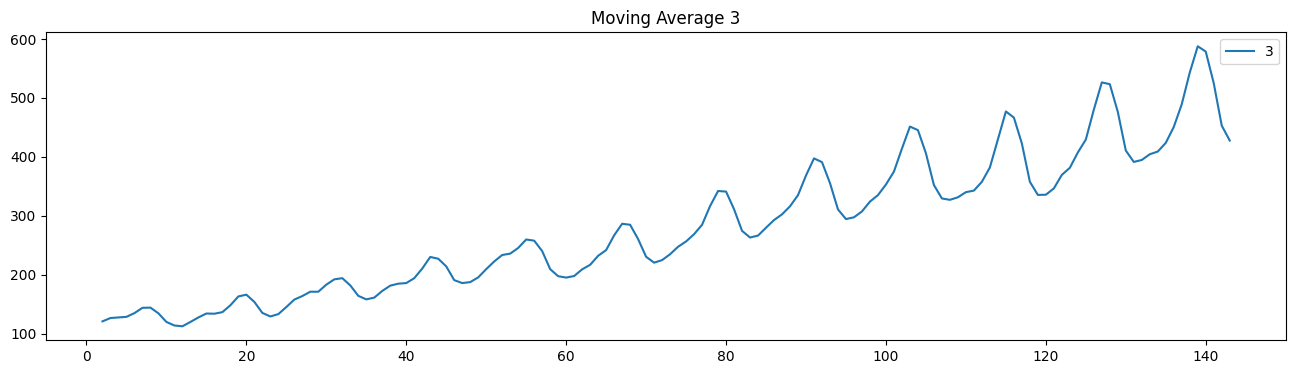

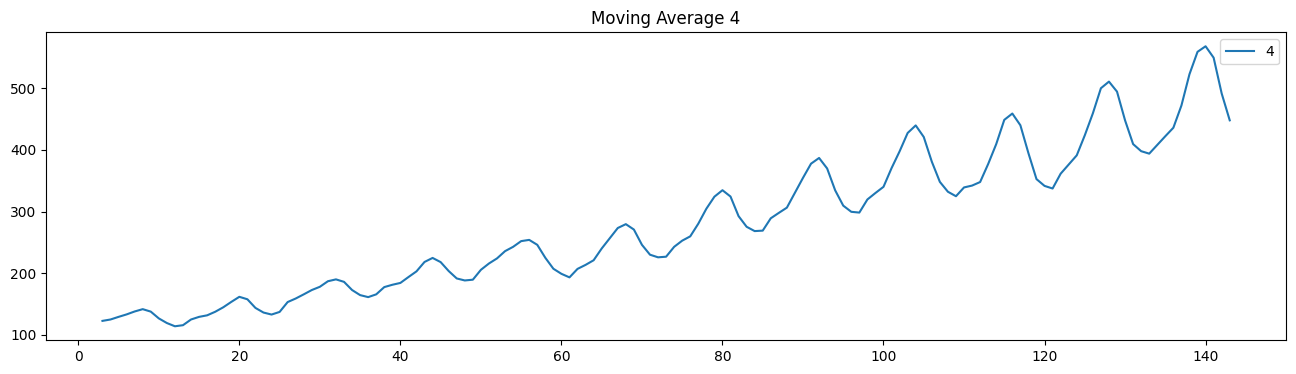

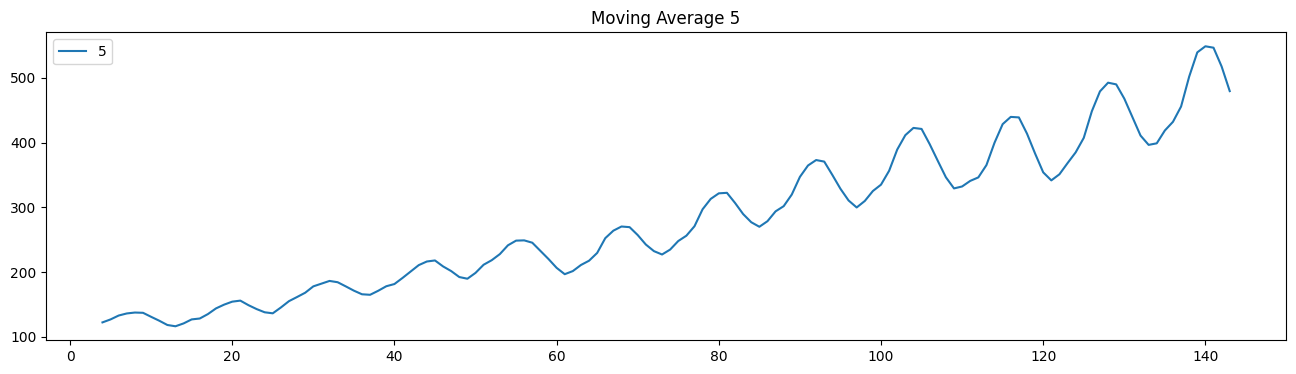

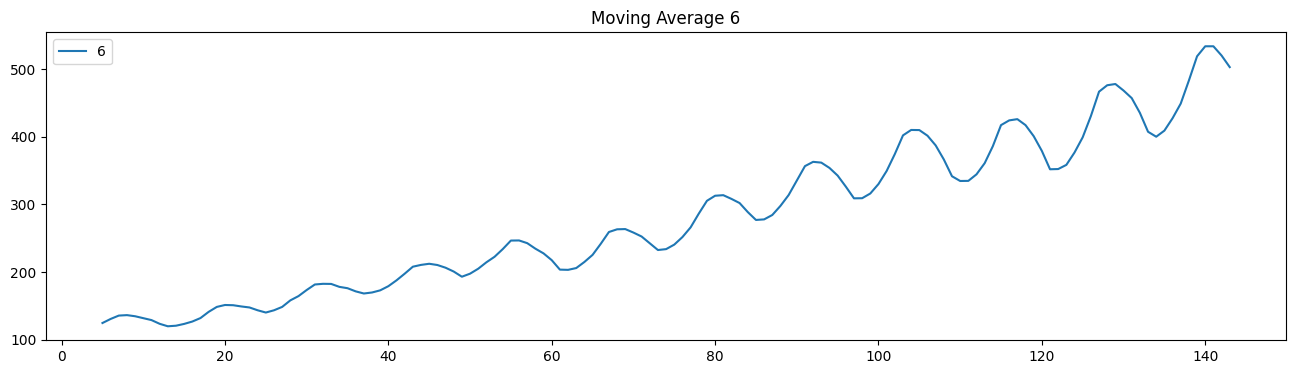

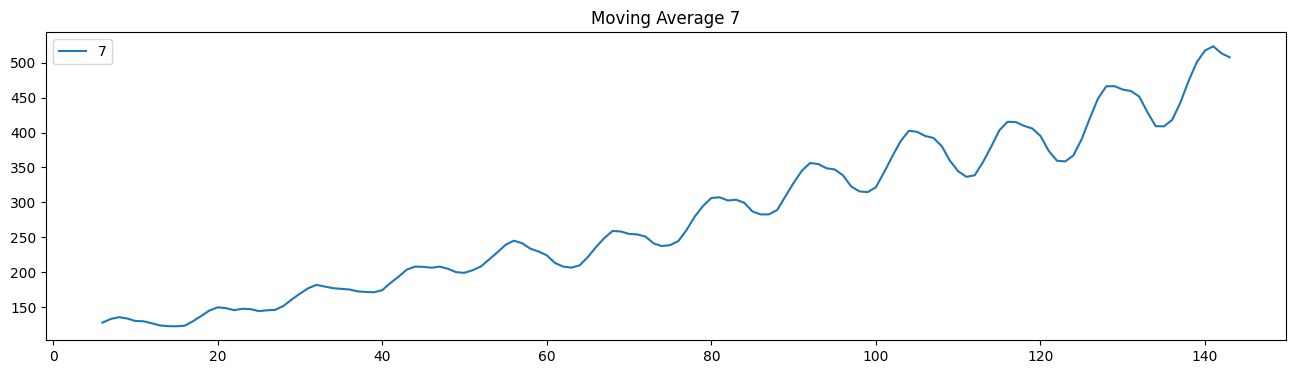

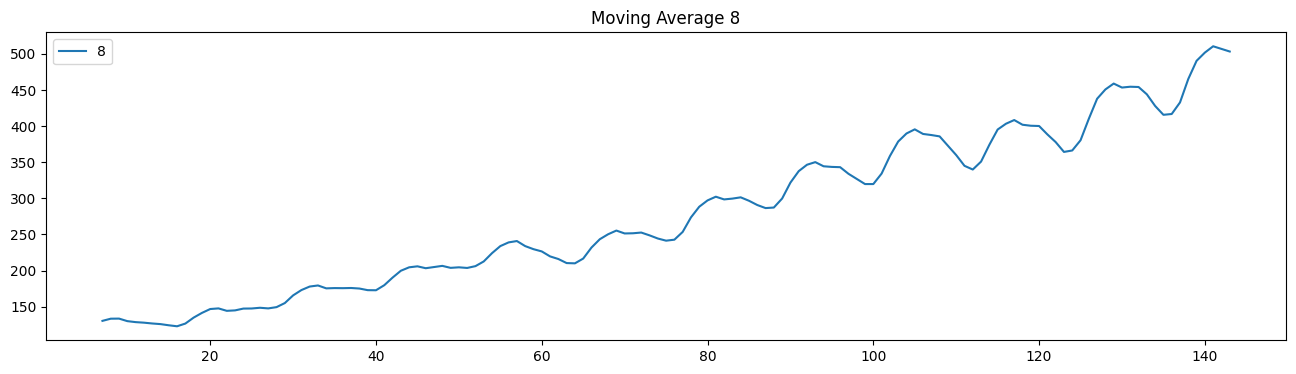

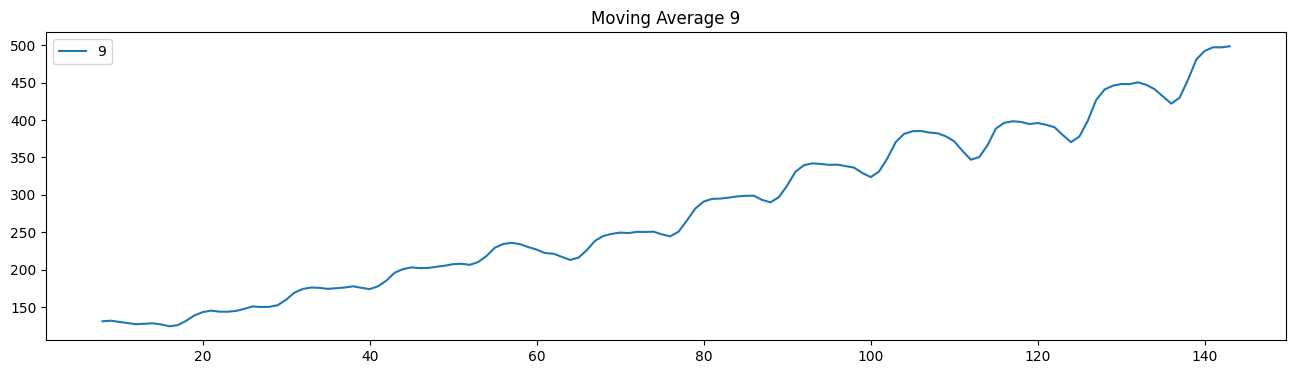

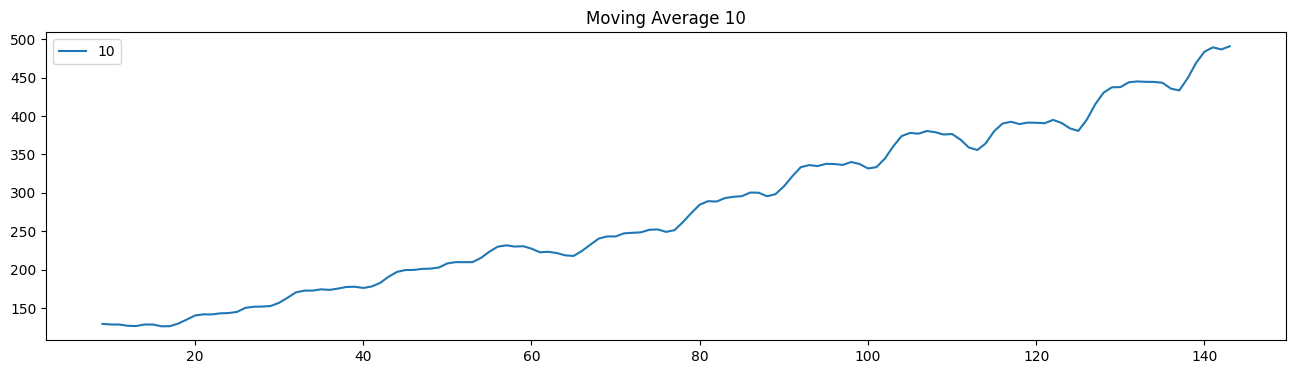

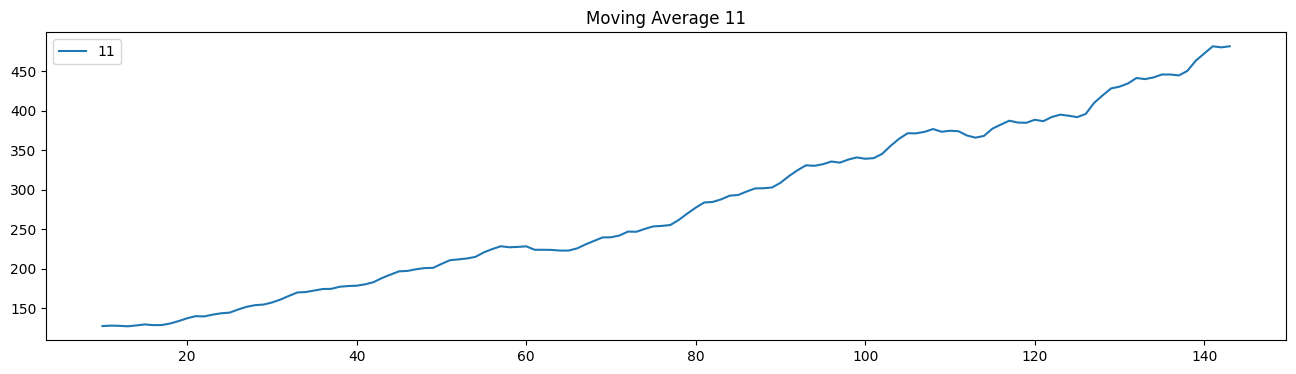

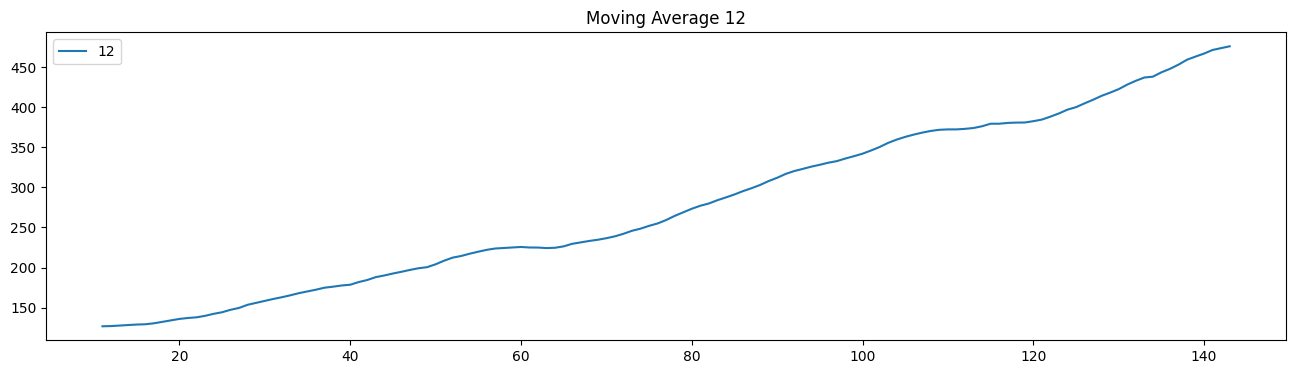

In [355]:
plt.figure(figsize=(16,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(16,4))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

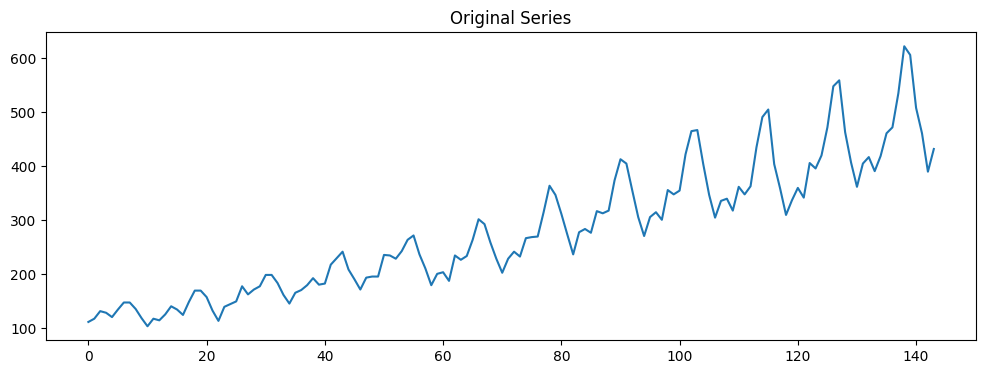

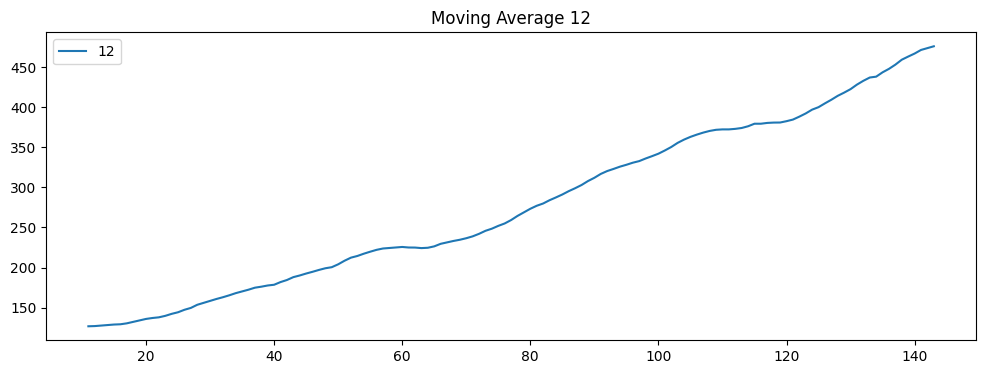

In [356]:
# Original Data
plt.figure(figsize=(12,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))

# Moving average 12
df["Passengers"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

## Time Series Decomposition plot

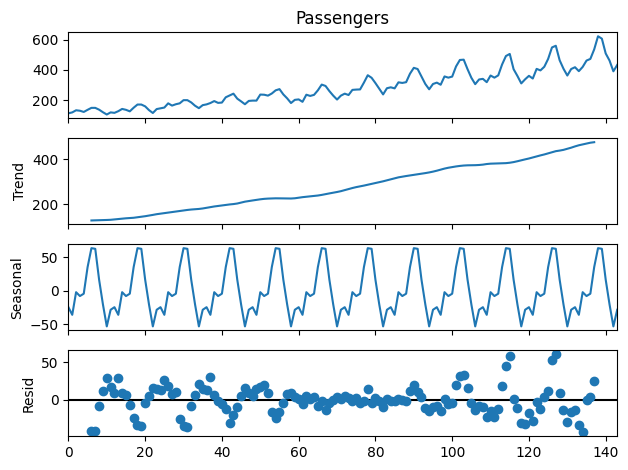

In [357]:
# Additive model
decompose_ts_add = seasonal_decompose(df['Passengers'], model = 'additive', period=12) # Assuming monthly data, so period=12
decompose_ts_add.plot()
plt.show()

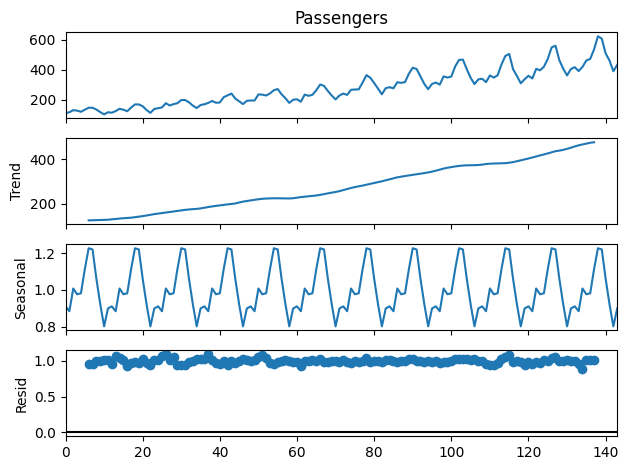

In [358]:
# Multiplicative model
decompose_ts_mul = seasonal_decompose(df['Passengers'], model = 'multiplicative', period=12) # Assuming monthly data, so period=12
decompose_ts_mul.plot()
plt.show()

## ACF and PACF plots

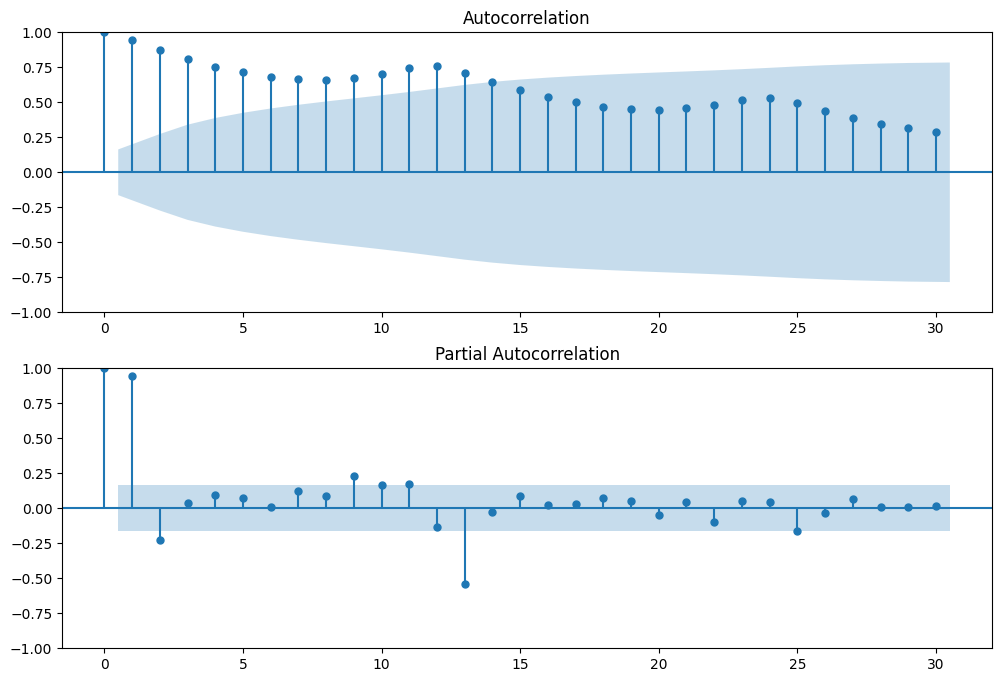

In [359]:
# Plot the ACF and PACF plots for the original time series
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Passengers'], lags=30, ax=ax[0])
plot_pacf(df['Passengers'], lags=30, ax=ax[1])
plt.show()

## Stationarity Check

In [360]:
from statsmodels.tsa.stattools import adfuller

In [361]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color = 'black', label = 'Rolling std')

    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [362]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(timeseries):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries.dropna())
    #print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    #print('Critical Values:')
    #for key, value in result[4].items():
        #print('\t%s: %.3f' % (key, value))

    # Interpret results
    if result[1] <= 0.05:
        print("Reject the null hypothesis (H0)")
        print('Data is stationary.')
    else:
        print("Fail to reject the null hypothesis (H0)")
        print('Data is non-stationary.')

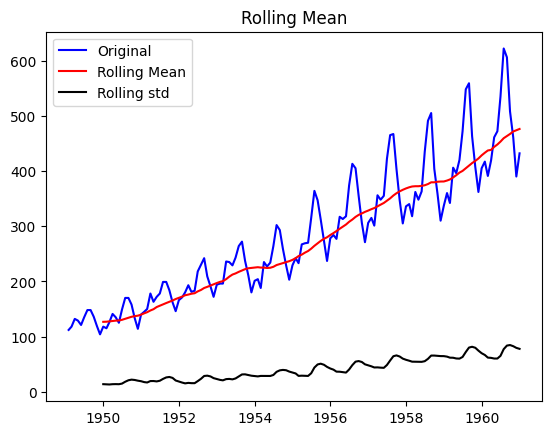

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [363]:
test_stationarity(df1)

In [364]:
adfuller_test(df1)

p-value: 0.991880243437641
Fail to reject the null hypothesis (H0)
Data is non-stationary.


# Feature Scaling

## 1. Square Root Transformation

In [365]:
# Creating square_root Dataframe
square_root= pd.DataFrame()
square_root = df1[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)
square_root

,Passengers
Date,
1949-01-31,10.583005
1949-02-28,10.862780
1949-03-31,11.489125
1949-04-30,11.357817
1949-05-31,11.000000
...,...
1960-08-31,24.617067
1960-09-30,22.538855
1960-10-31,21.470911


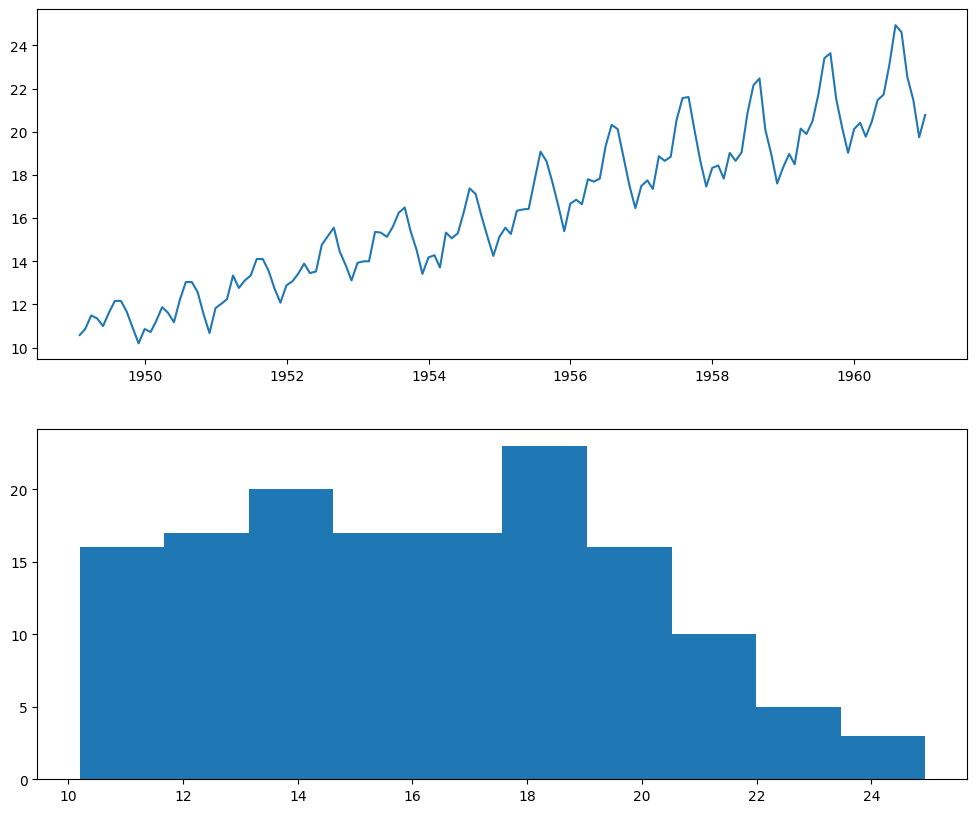

In [366]:
# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Passengers'])

#Histogram
plt.subplot(212)
plt.hist(square_root['Passengers'])
plt.show()

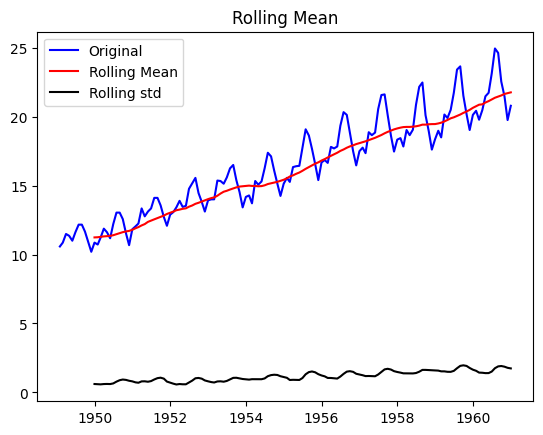

Results of Dickey Fuller Test:
Test Statistic                  -0.345854
p-value                          0.918754
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [367]:
test_stationarity(square_root)

In [368]:
adfuller_test(square_root)

p-value: 0.9187543217618346
Fail to reject the null hypothesis (H0)
Data is non-stationary.


## 2. Log transformation

In [369]:
log = pd.DataFrame()
log = df1[['Passengers']]
log['Passengers'] = np.log(log.Passengers)
log

,Passengers
Date,
1949-01-31,4.718499
1949-02-28,4.770685
1949-03-31,4.882802
1949-04-30,4.859812
1949-05-31,4.795791
...,...
1960-08-31,6.406880
1960-09-30,6.230481
1960-10-31,6.133398


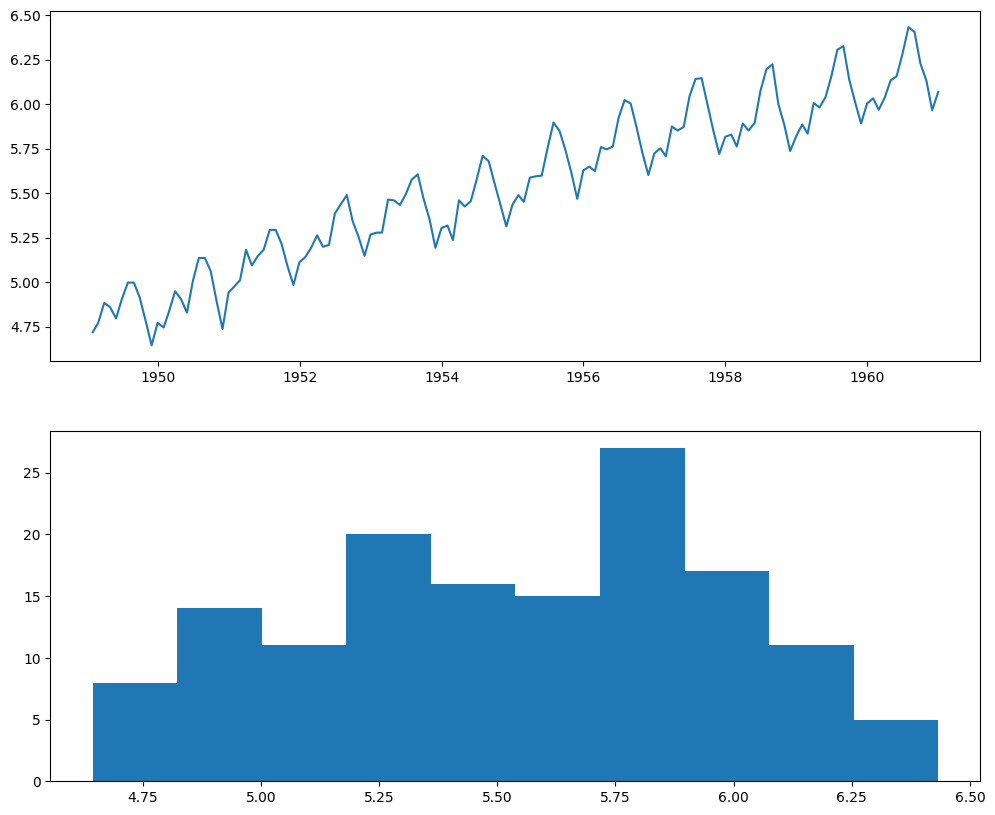

In [370]:
# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])

#Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()

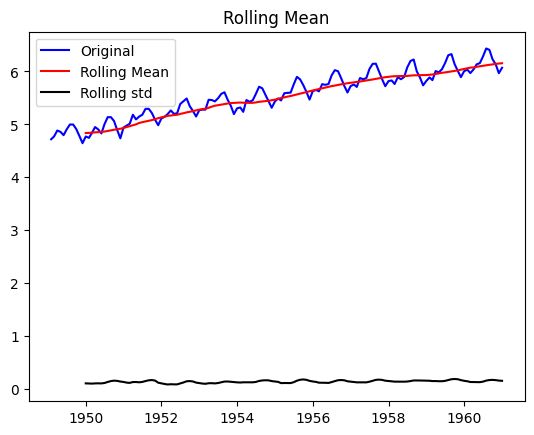

Results of Dickey Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [371]:
test_stationarity(log)

In [372]:
adfuller_test(log)

p-value: 0.4223667747703874
Fail to reject the null hypothesis (H0)
Data is non-stationary.


## 3. Differencing

### Finding the best differencing order

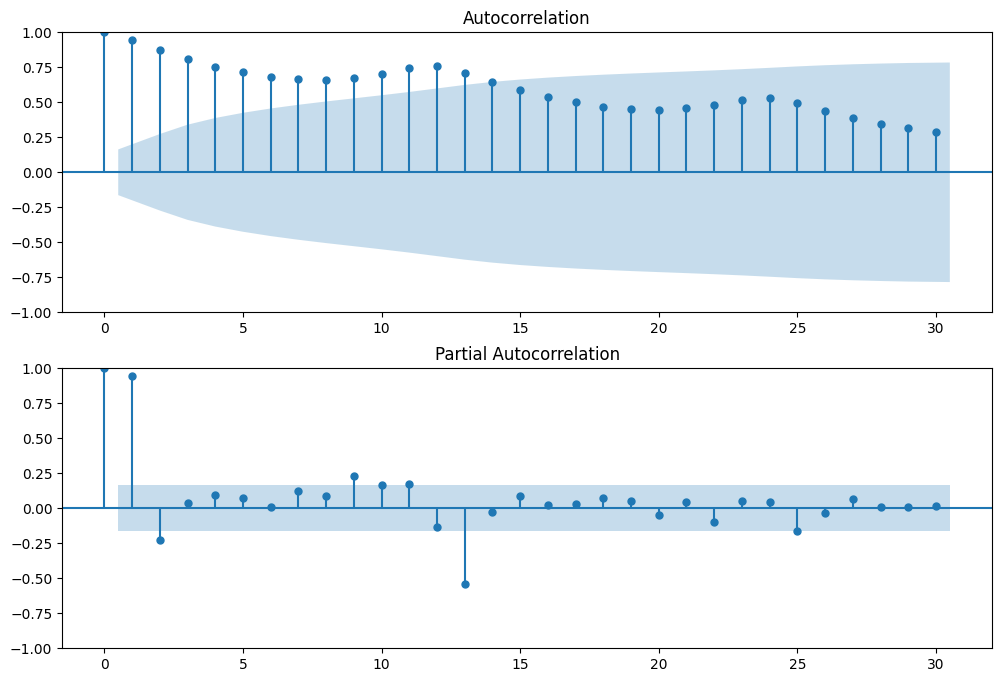

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Differencing order 1:
ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


Differencing order 2:
ADF Statistic: -2.961695135555418
p-value: 0.03862975767698902
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


Differencing order 3:
ADF Statistic: -2.8865058565449693
p-value: 0.04693983572510773
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


Differencing order 4:
ADF Statistic: -3.0289473658493042
p-value: 0.03227809309801966
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


Differencing order 5:
ADF Statistic: -2.7860146339665905
p-value: 0.06029941457141702
Critica

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Plot the ACF and PACF plots for the original time series
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df1['Passengers'], lags=30, ax=ax[0])
plot_pacf(df1['Passengers'], lags=30, ax=ax[1])
plt.show()

# Perform ADF test to check stationarity of the original time series
adf_result = adfuller(df1['Passengers'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

# Try different values of differencing
best_diff_order = 0
best_p_value = adf_result[1]
for diff_order in range(1, 13):
    differenced_data = df1['Passengers'].diff(diff_order).dropna()
    adf_result = adfuller(differenced_data)
    print(f'Differencing order {diff_order}:')
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:', adf_result[4])
    print('\n')
    if adf_result[1] < 0.05 and adf_result[1] < best_p_value:
        best_diff_order = diff_order
        best_p_value = adf_result[1]

print(f'Best differencing order: {best_diff_order}')

#### We have got the best differencing order as 10

## Plot the ACF and PACF plots for the best differenced time series

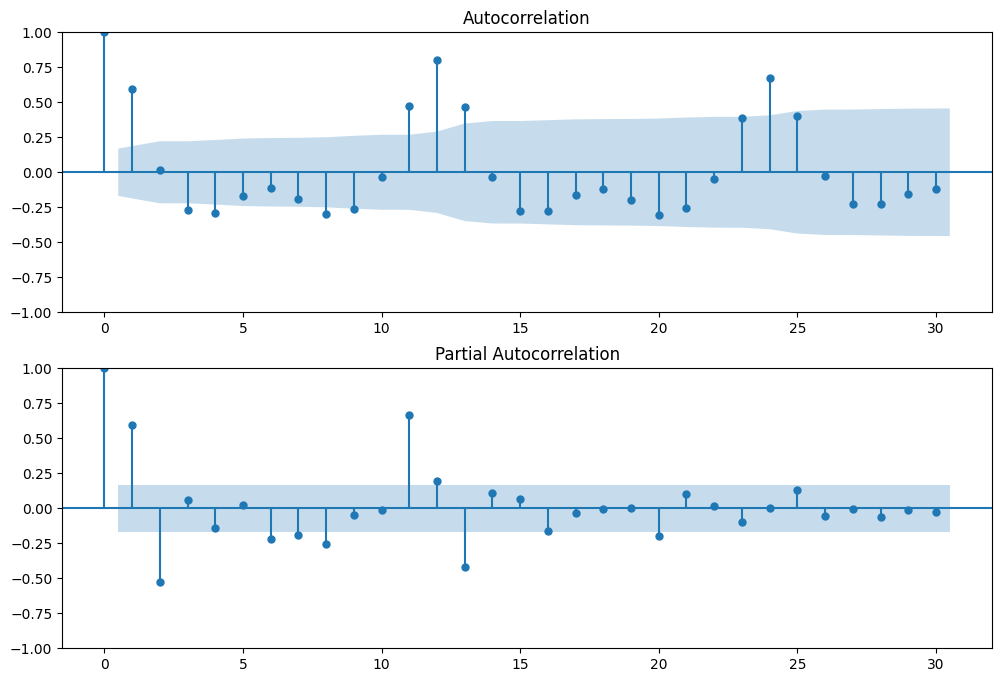

In [374]:
best_differenced_data = df1['Passengers'].diff(best_diff_order).dropna()
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(best_differenced_data, lags=30, ax=ax[0])
plot_pacf(best_differenced_data, lags=30, ax=ax[1])
plt.show()

In [375]:
best_differenced_data = pd.DataFrame(best_differenced_data)
diff = best_differenced_data.copy()
diff

,Passengers
Date,
1949-11-30,-8.0
1949-12-31,0.0
1950-01-31,-17.0
1950-02-28,-3.0
1950-03-31,20.0
...,...
1960-08-31,199.0
1960-09-30,146.0
1960-10-31,56.0


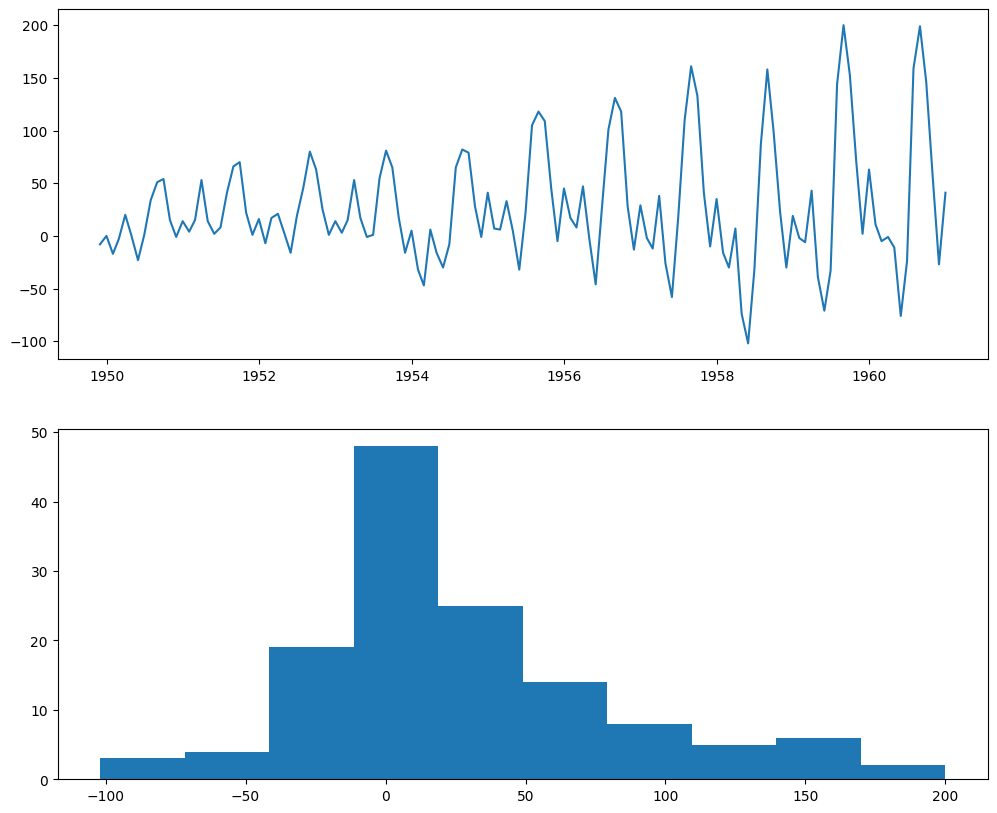

In [376]:
# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(diff['Passengers'])

#Histogram
plt.subplot(212)
plt.hist(diff['Passengers'])
plt.show()

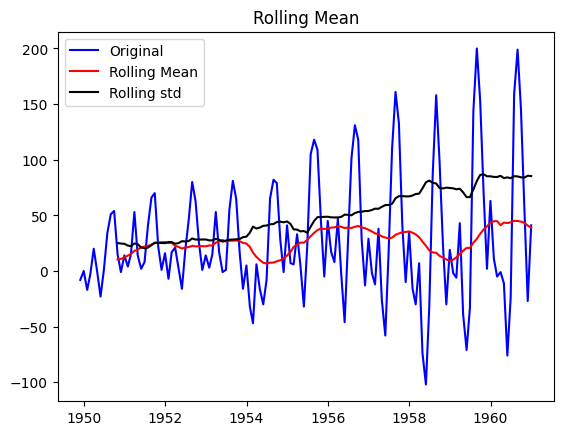

Results of Dickey Fuller Test:
Test Statistic                  -3.671914
p-value                          0.004526
#Lags Used                      13.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


In [377]:
test_stationarity(diff)

In [378]:
adfuller_test(diff)

p-value: 0.004526004061261908
Reject the null hypothesis (H0)
Data is stationary.


#### Here by Differencing our time series data became stationary

## Data Partition

#### Utilizing the last 2 years for the testing purpose and preceding data for the training purpose

In [379]:
size = -24

# Partition the data into train and test sets
Train = diff.iloc[:-24]
Test = diff.iloc[-24:]

In [380]:
# Print the lengths of train and test sets
print("Train set length:", len(Train))
print("Test set length:", len(Test))

Train set length: 110
Test set length: 24


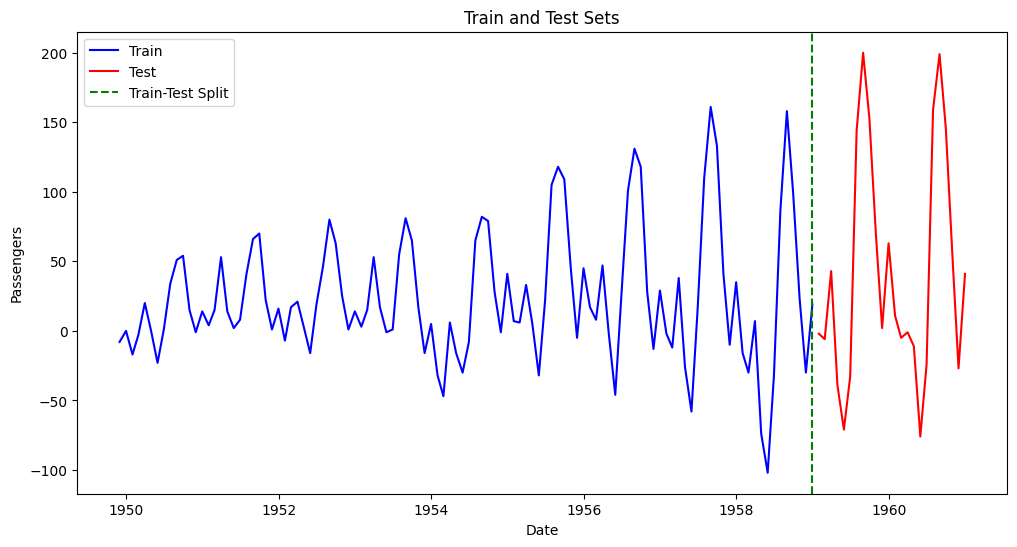

In [381]:
# Plotting train and test sets
plt.figure(figsize=(12, 6))
plt.plot(Train.index, Train['Passengers'], label='Train', color = 'blue')
plt.plot(Test.index, Test['Passengers'], label='Test', color = 'red')
plt.axvline(x=Train.index[-1], color='green', linestyle='--', label='Train-Test Split')
plt.title('Train and Test Sets')
plt.title('Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## Building Forecasting Models

### Evaluation Metric MAPE

In [382]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

### Simple Exponential Method


##### Parameter tuning

In [383]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Define a range of values for alpha
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Create a list to store MAPE scores for different values of alpha
mape_scores = []

# Iterate over all values of alpha
for alpha in alphas:
    # Fit the model with current value of alpha
    ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=alpha)

    # Generate predictions
    pred_ses = ses_model.predict(start=Test.index[0], end=Test.index[-1])

    # Calculate MAPE using the provided function
    mape = MAPE(pred_ses, Test["Passengers"])

    # Store the MAPE score and alpha value
    mape_scores.append((mape, alpha))

# Find the alpha value with the lowest MAPE
best_mape, best_alpha = min(mape_scores)

print("Best MAPE:", best_mape)
print("Best alpha:", best_alpha)

Best MAPE: 205.0243253994078
Best alpha: 0.7


In [384]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=best_alpha)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers)

205.0243253994078

In [385]:
rmse_ses = np.sqrt(mean_squared_error(Test["Passengers"], pred_ses))
print("Root Mean Squared Error (RMSE):", rmse_ses)

Root Mean Squared Error (RMSE): 86.96890992126708


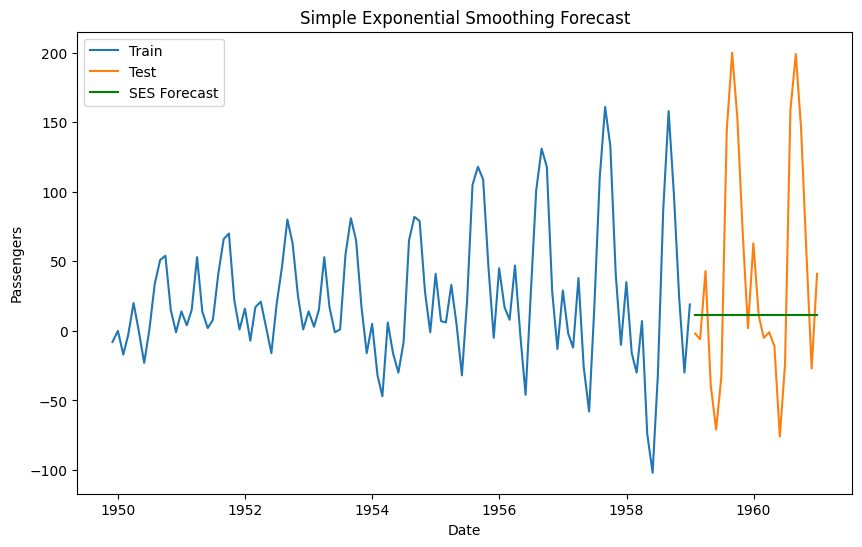

In [386]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Passengers"], label='Train')
plt.plot(Test.index, Test["Passengers"], label='Test')
plt.plot(Test.index, pred_ses, label='SES Forecast', color='green')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## Holt method

##### Parameter tuning

In [387]:
import numpy as np
from statsmodels.tsa.holtwinters import Holt
from itertools import product

# Define a range of values for smoothing_level and smoothing_slope
smoothing_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
smoothing_slopes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Create a list to store MAPE scores for different combinations of parameters
mape_scores = []

# Iterate over all combinations of parameters
for smoothing_level, smoothing_slope in product(smoothing_levels, smoothing_slopes):
    # Fit the model with current parameter combination
    hw_model = Holt(Train["Passengers"]).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)

    # Generate predictions
    pred_hw = hw_model.predict(start=Test.index[0], end=Test.index[-1])

    # Calculate MAPE using the provided function
    mape = MAPE(pred_hw, Test["Passengers"])

    # Store the MAPE score and parameter combination
    mape_scores.append((mape, smoothing_level, smoothing_slope))

# Find the parameter combination with the lowest MAPE
best_mape, best_smoothing_level, best_smoothing_slope = min(mape_scores)

print("Best MAPE:", best_mape)
print("Best smoothing_level:", best_smoothing_level)
print("Best smoothing_slope:", best_smoothing_slope)

Best MAPE: 135.40889629560897
Best smoothing_level: 0.9
Best smoothing_slope: 0.1


In [388]:
# Holt method
hw_model = Holt(Train["Passengers"]).fit(smoothing_level = best_smoothing_level,
                                         smoothing_slope = best_smoothing_slope)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
print('MAPE :',MAPE(pred_hw,Test.Passengers))

MAPE : 135.40889629560897


In [389]:
rmse_hw_model = np.sqrt(mean_squared_error(Test["Passengers"], pred_hw))
print("Root Mean Squared Error (RMSE):", rmse_hw_model)

Root Mean Squared Error (RMSE): 93.25382295042759


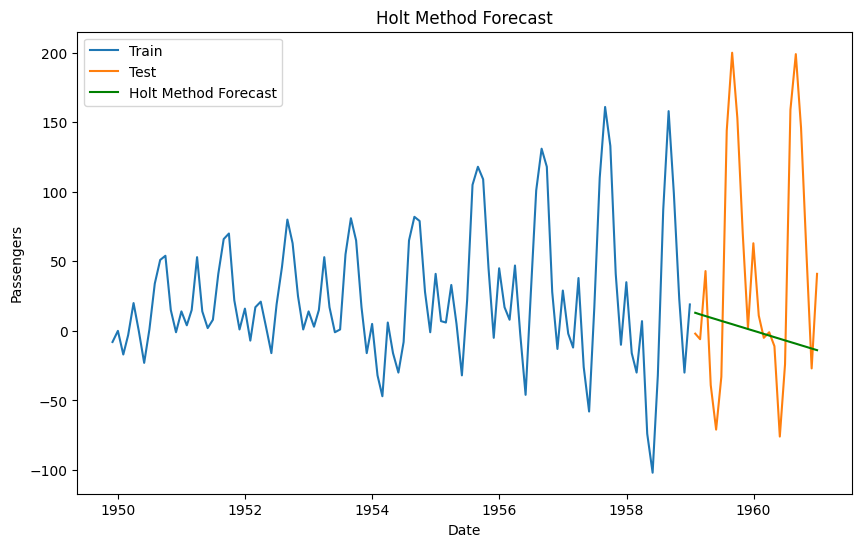

In [390]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Passengers"], label='Train')
plt.plot(Test.index, Test["Passengers"], label='Test')
plt.plot(Test.index, pred_hw, label='Holt Method Forecast', color='green')
plt.title('Holt Method Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

### Holts winter exponential smoothing with additive seasonality and additive trend

In [391]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
print('MAPE :', MAPE(pred_hwe_add_add,Test.Passengers))

MAPE : 270.5353044267369


In [392]:
rmse_hwe_model_add_add = np.sqrt(mean_squared_error(Test["Passengers"], pred_hwe_add_add))
print("Root Mean Squared Error (RMSE):", rmse_hwe_model_add_add)

Root Mean Squared Error (RMSE): 32.01078995661521


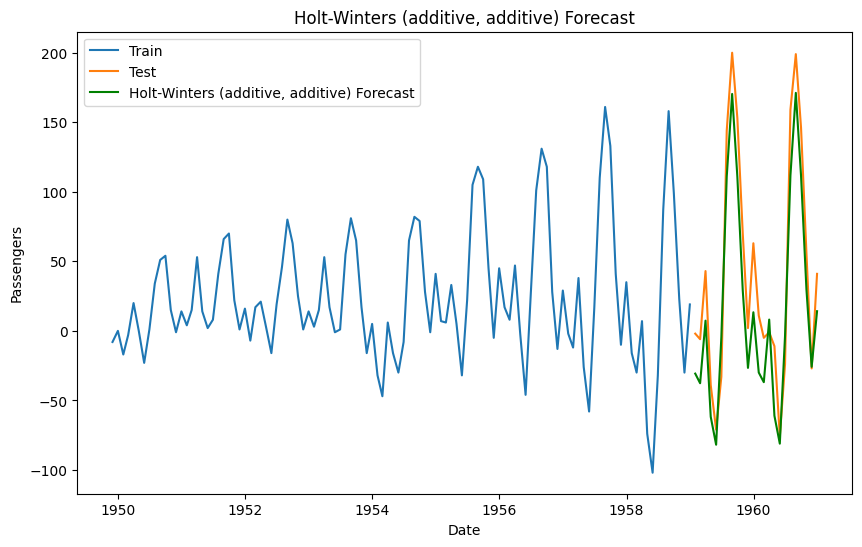

In [393]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Passengers"], label='Train')
plt.plot(Test.index, Test["Passengers"], label='Test')
plt.plot(Test.index, pred_hwe_add_add, label='Holt-Winters (additive, additive) Forecast', color='green')
plt.title('Holt-Winters (additive, additive) Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [394]:
min_value = Train["Passengers"].min()

# Add a constant to shift all values to make them positive
Train["Passengers_positive"] = Train["Passengers"] - min_value + 1  # Add 1 to ensure all values are positive

# Fit Holt-Winters model using the preprocessed data
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers_positive"], seasonal="mul", trend="add", seasonal_periods=12).fit()
#hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

1051.4992918845592

In [395]:
rmse_hwe_model_mul_add = np.sqrt(mean_squared_error(Test["Passengers"], pred_hwe_mul_add))
print("Root Mean Squared Error (RMSE):", rmse_hwe_model_mul_add)

Root Mean Squared Error (RMSE): 79.16406240033344


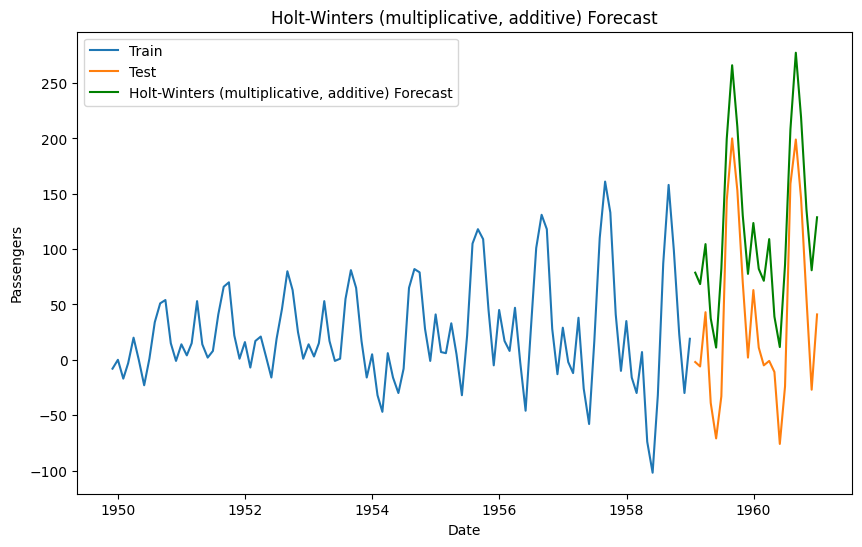

In [396]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train["Passengers"], label='Train')
plt.plot(Test.index, Test["Passengers"], label='Test')
plt.plot(Test.index, pred_hwe_mul_add, label='Holt-Winters (multiplicative, additive) Forecast', color='green')
plt.title('Holt-Winters (multiplicative, additive) Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## ARIMA

In [397]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Define the range of p, d, and q values
p_values = range(0, 5)  # AR order
d_values = range(0, 5)  # Differencing order
q_values = range(0, 5)  # MA order

# Generate all possible combinations of p, d, and q values
pdq = list(itertools.product(p_values, d_values, q_values))

best_aic = float("inf")
best_pdq = None

# Iterate over all combinations and select the one with the lowest AIC
for params in pdq:
    try:
        model = ARIMA(Train['Passengers'], order=params)
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_pdq = params
    except:
        continue

# Fit the best ARIMA model
best_model = ARIMA(Train['Passengers'], order=best_pdq)
best_results = best_model.fit()

# Print the best model summary
best_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  110
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -521.042
Date:                Thu, 02 May 2024   AIC                           1056.084
Time:                        08:04:58   BIC                           1074.924
Sample:                    11-30-1949   HQIC                          1063.725
                         - 12-31-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2774      0.075     -3.678      0.000      -0.425      -0.130
ar.L2         -0.5551      0.120     -4.639      0.000      -0.790      -0.321
ma.L1          0.4544   1269.545      0.000      1.000   -2487.809    2488.718
ma.L2         -0.0005    575.151  -8.41e-07      1.000   -1127.275    1127.274
ma.L3         -0.4544   1268.875     -0.000      1.000   -2487.404    2486.495
ma.L4         -0.9995      0.152     -6.583      0.000      -1.297      -0.702
sigma2       739.4293      5.343    138.379      0.000     728.956     749.902
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.93   Prob(JB):                         0.96
Heteroskedasticity (H):               3.48   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.68e+21. Standard errors may be unstable.
"""

In [398]:
best_p, best_d, best_q = best_pdq
best_order = (best_p, best_d, best_q)
print('Order :',best_order)

Order : (2, 1, 4)


In [399]:
# Build the ARIMA(1, 1, 0) model
model = ARIMA(Train['Passengers'], order = best_order)
results = model.fit()

# Print the model summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  110
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -521.042
Date:                Thu, 02 May 2024   AIC                           1056.084
Time:                        08:04:59   BIC                           1074.924
Sample:                    11-30-1949   HQIC                          1063.725
                         - 12-31-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2774      0.075     -3.678      0.000      -0.425      -0.130
ar.L2         -0.5551      0.120     -4.639      0.000      -0.790      -0.321
ma.L1          0.4544   1269.545      0.000      1.000   -2487.809    2488.718
ma.L2         -0.0005    575.151  -8.41e-07      1.000   -1127.275    1127.274
ma.L3         -0.4544   1268.875     -0.000      1.000   -2487.404    2486.495
ma.L4         -0.9995      0.152     -6.583      0.000      -1.297      -0.702
sigma2       739.4293      5.343    138.379      0.000     728.956     749.902
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.93   Prob(JB):                         0.96
Heteroskedasticity (H):               3.48   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.68e+21. Standard errors may be unstable.
"""

In [400]:
start = len(Train)
end = start + len(Test) - 1  # Assuming 'test' is your test data

# Forecast the test data
arima_predictions = results.predict(start=start, end=end, typ='levels')

# Print the forecast
arima_predictions

1959-01-31    49.190541
1959-02-28    19.930682
1959-03-31    38.060117
1959-04-30    22.126315
1959-05-31    16.482863
1959-06-30    26.893941
1959-07-31    27.138296
1959-08-31    21.290998
1959-09-30    22.777649
1959-10-31    25.611197
1959-11-30    23.999760
1959-12-31    22.873857
1960-01-31    24.080790
1960-02-29    24.370956
1960-03-31    23.620446
1960-04-30    23.667591
1960-05-31    24.071141
1960-06-30    23.933007
1960-07-31    23.747309
1960-08-31    23.875512
1960-09-30    23.943030
1960-10-31    23.853128
1960-11-30    23.840589
1960-12-31    23.893975
Freq: M, Name: predicted_mean, dtype: float64

#### Note : ARIMA model won't capture the Seasonality in the data
#### We can conclude it from the above predicted values

In [401]:
from statsmodels.tools.eval_measures import rmse

# Calculate mean squared error
print('MSE :',mean_squared_error(Test["Passengers"], arima_predictions))

# Calculate root mean squared error
rmse_arima = rmse(Test["Passengers"], arima_predictions)
print('RMSE :', rmse_arima)

MSE : 6993.095139121956
RMSE : 83.62472803616139


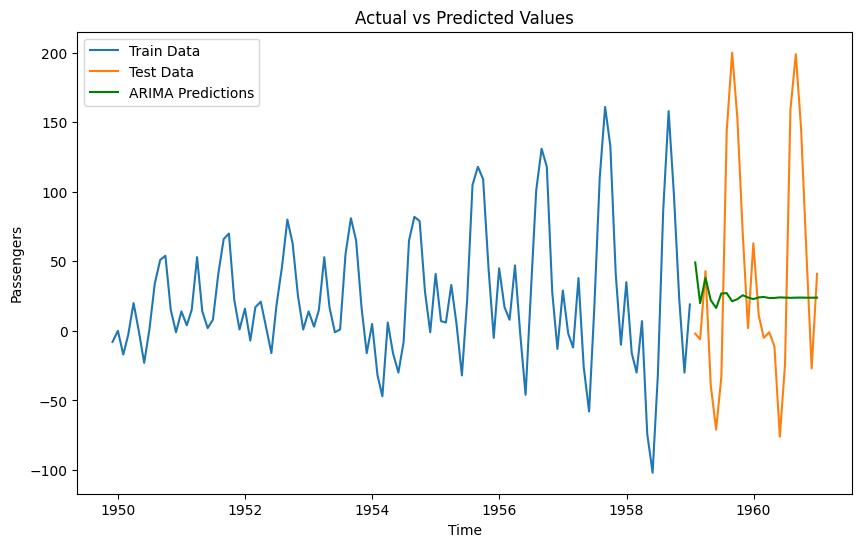

In [402]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train['Passengers'], label='Train Data')
plt.plot(Test.index, Test['Passengers'], label='Test Data')
plt.plot(arima_predictions.index, arima_predictions, color='green', label='ARIMA Predictions')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## Auto ARIMA Model Training

In [403]:
stepwise_fit = auto_arima(Train['Passengers'], start_p = 1, start_q = 1,
                          max_p = 5, max_q = 5, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = None, trace = True,
                          error_action ='ignore', # we don't want to know if an order does not work
                          suppress_warnings = True, # we don't want convergence warnings
                          stepwise = True)     # set to stepwise

# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=805.878, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=882.834, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=805.665, Time=0.37 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=839.894, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=880.839, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=804.853, Time=0.09 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=805.675, Time=0.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=807.662, Time=0.36 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=803.199, Time=0.20 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=804.825, Time=0.46 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=804.870, Time=0.50 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=806.716, Time=0.78 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=801.123, Time=0.30 sec
 ARIMA(3,0,0)(1,1,0)[12] intercept   : AIC=803.122, Time=0.64 sec
 ARIMA(3,0,0)(0,1,1)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  110
Model:             SARIMAX(4, 0, 1)x(0, 1, [], 12)   Log Likelihood                -392.779
Date:                             Thu, 02 May 2024   AIC                            799.559
Time:                                     08:05:23   BIC                            817.654
Sample:                                 11-30-1949   HQIC                           806.878
                                      - 12-31-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4506      2.636     -0.171      0.864      -5.617       4.715
ar.L1         -0.2961      0.104     -2.845      0.004      -0.500      -0.092
ar.L2          0.9210      0.125      7.360      0.000       0.676       1.166
ar.L3          0.1344      0.090      1.496      0.135      -0.042       0.310
ar.L4         -0.2591      0.101     -2.578      0.010      -0.456      -0.062
ma.L1          0.9869      0.156      6.319      0.000       0.681       1.293
sigma2       167.4863     32.543      5.147      0.000     103.704     231.268
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 3.38
Prob(Q):                              0.73   Prob(JB):                         0.18
Heteroskedasticity (H):               1.30   Skew:                            -0.37
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [404]:
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order

In [405]:
print('Order :', best_order)
print('Seasonal Order :', best_seasonal_order)

Order : (4, 0, 1)
Seasonal Order : (0, 1, 0, 12)


## SARIMA

In [406]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMAX model using the provided specifications
sarimax_model = SARIMAX(Train['Passengers'],
                        order = best_order,
                        seasonal_order = best_seasonal_order)

# Fit the SARIMAX model to the training data
sarimax_result = sarimax_model.fit()

# Print the summary of the fitted SARIMAX model
sarimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Passengers   No. Observations:                  110
Model:             SARIMAX(4, 0, 1)x(0, 1, [], 12)   Log Likelihood                -392.679
Date:                             Thu, 02 May 2024   AIC                            797.357
Time:                                     08:05:24   BIC                            812.867
Sample:                                 11-30-1949   HQIC                           803.631
                                      - 12-31-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2957      0.106     -2.790      0.005      -0.503      -0.088
ar.L2          0.9242      0.129      7.156      0.000       0.671       1.177
ar.L3          0.1347      0.093      1.443      0.149      -0.048       0.318
ar.L4         -0.2618      0.104     -2.525      0.012      -0.465      -0.059
ma.L1          0.9990      1.751      0.570      0.568      -2.434       4.432
sigma2       170.8717    295.557      0.578      0.563    -408.409     750.152
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 3.41
Prob(Q):                              0.75   Prob(JB):                         0.18
Heteroskedasticity (H):               1.32   Skew:                            -0.37
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [407]:
# Forecast
start = len(Train)
end = start + len(Test) - 1

# Generate predictions
sarima_predictions = sarimax_result.predict(start = start,
                             end = end,
                             dynamic=False)

# Print the predictions
sarima_predictions.head()

1959-01-31    -24.516767
1959-02-28    -40.252196
1959-03-31      5.239904
1959-04-30    -79.913949
1959-05-31   -101.029835
Freq: M, Name: predicted_mean, dtype: float64

In [408]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate mean squared error
print('MSE :',mean_squared_error(Test["Passengers"], sarima_predictions))

# Calculate root mean squared error
rmse_sarima = rmse(Test["Passengers"], sarima_predictions)
print('RMSE :', rmse_sarima)

MSE : 1555.0537566101154
RMSE : 39.434169911513486


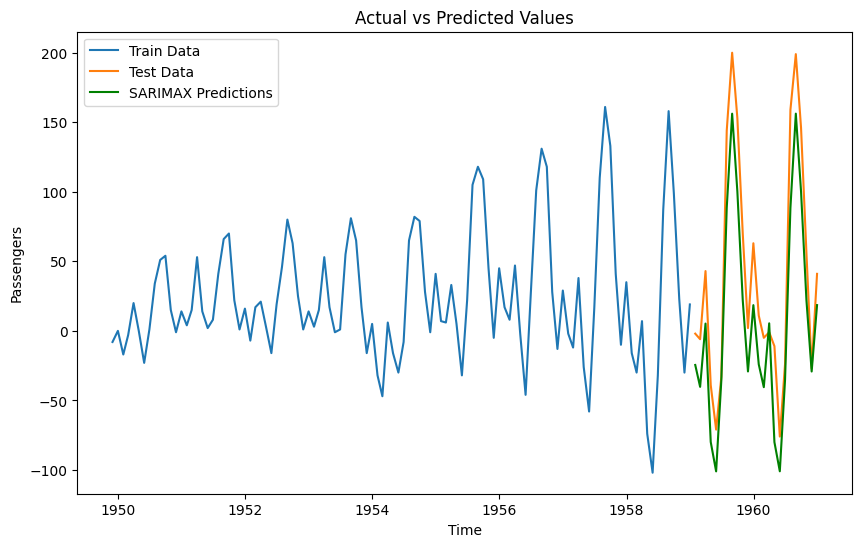

In [409]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(Train.index, Train['Passengers'], label='Train Data')
plt.plot(Test.index, Test['Passengers'], label='Test Data')
plt.plot(sarima_predictions.index, sarima_predictions, color='green', label='SARIMAX Predictions')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [410]:
#Compare the results
data1 = {"MODEL":pd.Series(["SES", "Holt", 'hwe_model_add_add', 'hwe_model_mul_add', 'ARIMA', 'SARIMA']),
        "RMSE_Values":pd.Series([rmse_ses, rmse_hw_model, rmse_hwe_model_add_add, rmse_hwe_model_mul_add, rmse_arima, rmse_sarima])}
type(data1)

table_rmse1 = pd.DataFrame(data1)
table_rmse1.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
2,hwe_model_add_add,32.010790
5,SARIMA,39.434170
3,hwe_model_mul_add,79.164062
4,ARIMA,83.624728
0,SES,86.968910
1,Holt,93.253823


## Visualizing models performance

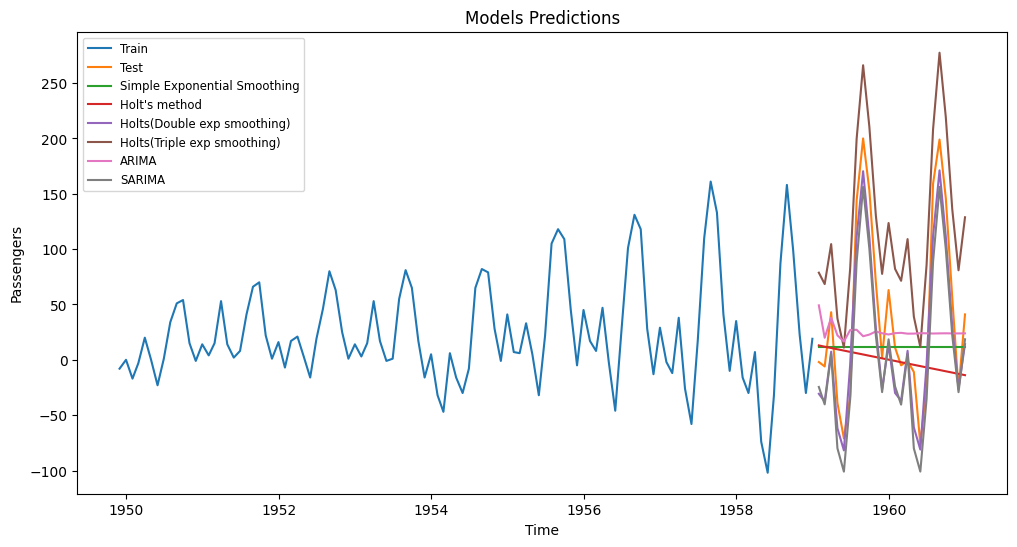

In [411]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(Train['Passengers'], label='Train')
plt.plot(Test.index, Test['Passengers'], label='Test')

# Plot predicted data
plt.plot(Test.index, pred_ses, label='Simple Exponential Smoothing')
plt.plot(Test.index, pred_hw, label="Holt's method")
plt.plot(Test.index, pred_hwe_add_add, label='Holts(Double exp smoothing)')
plt.plot(Test.index, pred_hwe_mul_add, label='Holts(Triple exp smoothing)')
plt.plot(Test.index, arima_predictions, label='ARIMA')
plt.plot(Test.index, sarima_predictions, label='SARIMA')

plt.title('Models Predictions')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend(loc = 'best', fontsize='small')
plt.show()

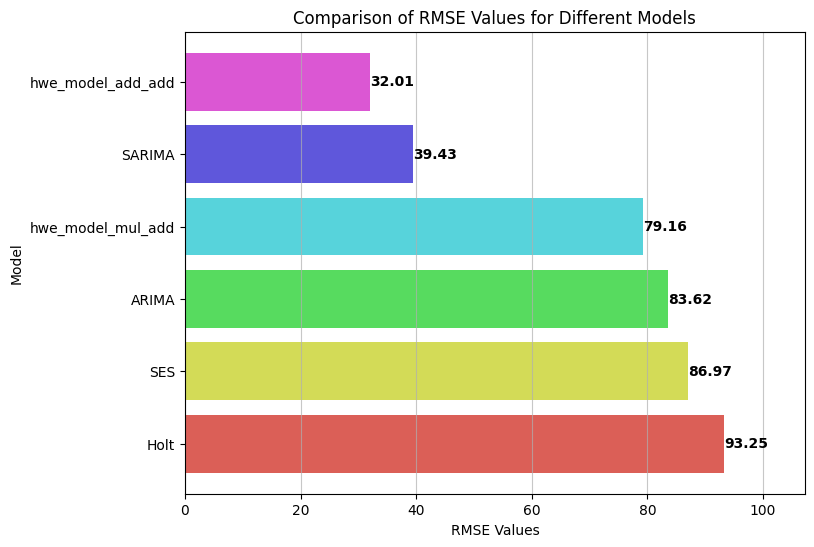

In [412]:
# Sort DataFrame by RMSE values in ascending order
table_rmse1 = table_rmse1.sort_values(by='RMSE_Values', ascending=False)

# Create a color palette using seaborn's 'hls' palette
colors = sns.color_palette('hls', len(table_rmse1))

# Create visualization with the 'hls' palette
plt.figure(figsize=(8, 6))
bars = plt.barh(table_rmse1['MODEL'], table_rmse1['RMSE_Values'], color=colors)
plt.xlabel('RMSE Values')
plt.ylabel('Model')
plt.title('Comparison of RMSE Values for Different Models')
plt.grid(axis='x', linestyle='-', alpha=0.7)

# Add RMSE values next to the bars
for bar, value in zip(bars, table_rmse1['RMSE_Values']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center', fontweight='bold')

# Adjust x-axis limits to accommodate annotations
plt.xlim(0, max(table_rmse1['RMSE_Values']) * 1.15)

plt.show()

## Training Holt's Double Exponential Smoothing model on entire data

In [413]:
hwe_model_add_add = ExponentialSmoothing(diff["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit()

#### Forecasting for the next 2 years

In [414]:
forecast_period = 24
hwe_model_add_add_forecast = hwe_model_add_add.forecast(steps=forecast_period)

# Print the forecast
print(hwe_model_add_add_forecast)

1961-01-31     -5.560458
1961-02-28    -17.381321
1961-03-31      0.722637
1961-04-30    -19.821871
1961-05-31    -82.144333
1961-06-30    -28.418408
1961-07-31    151.867496
1961-08-31    193.180902
1961-09-30    140.892650
1961-10-31     52.141784
1961-11-30    -25.593845
1961-12-31     44.798819
1962-01-31     -3.474097
1962-02-28    -15.294961
1962-03-31      2.808998
1962-04-30    -17.735510
1962-05-31    -80.057973
1962-06-30    -26.332047
1962-07-31    153.953856
1962-08-31    195.267263
1962-09-30    142.979011
1962-10-31     54.228144
1962-11-30    -23.507484
1962-12-31     46.885179
Freq: M, dtype: float64


### Converting the Differenced and Forecasted data back to original scale and creating visualization for it.

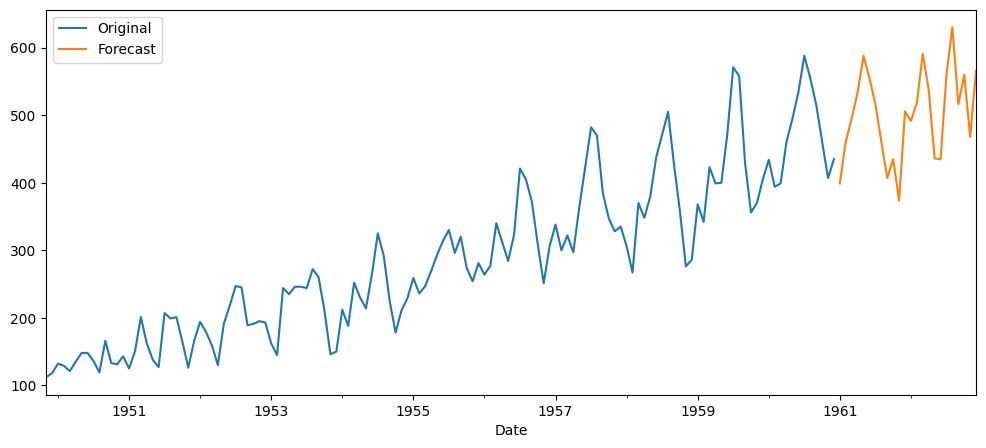

In [415]:
import pandas as pd
import matplotlib.pyplot as plt

# Reverse the differencing for passengers data
original_passengers = pd.Series(index=diff.index)
original_passengers[:10] = df["Passengers"].iloc[:10]
for i in range(10, len(original_passengers)):
    original_passengers.iloc[i] = original_passengers.iloc[i-10] + diff["Passengers"].iloc[i]

# Invert the differenced forecasts
original_forecast = pd.Series(index=hwe_model_add_add_forecast.index)
original_forecast.iloc[:10] = original_passengers.iloc[-10:]
for i in range(10, len(original_forecast)):
    original_forecast.iloc[i] = original_forecast.iloc[i-10] + hwe_model_add_add_forecast.iloc[i]

# Visualize the original data and forecast
plt.figure(figsize=(12, 5))
original_passengers.plot(label="Original")
original_forecast.plot(label="Forecast")
plt.legend()
plt.show()

## Data Pre-processing for model driven techniques

In [416]:
df2 = df.copy()
df2

,Date,Passengers,Month,Year
0,1949-01-31,112,Jan,1949
1,1949-02-28,118,Feb,1949
2,1949-03-31,132,Mar,1949
3,1949-04-30,129,Apr,1949
4,1949-05-31,121,May,1949
...,...,...,...,...
139,1960-08-31,606,Aug,1960
140,1960-09-30,508,Sep,1960
141,1960-10-31,461,Oct,1960
142,1960-11-30,390,Nov,1960


In [417]:
df2['t'] = range(1, len(df2) + 1)
df2['log_passengers'] = np.log(df2['Passengers'])
df2['t_square'] = np.square(df2['t'])
df2

,Date,Passengers,Month,Year,t,log_passengers,t_square
0,1949-01-31,112,Jan,1949,1,4.718499,1
1,1949-02-28,118,Feb,1949,2,4.770685,4
2,1949-03-31,132,Mar,1949,3,4.882802,9
3,1949-04-30,129,Apr,1949,4,4.859812,16
4,1949-05-31,121,May,1949,5,4.795791,25
...,...,...,...,...,...,...,...
139,1960-08-31,606,Aug,1960,140,6.406880,19600
140,1960-09-30,508,Sep,1960,141,6.230481,19881
141,1960-10-31,461,Oct,1960,142,6.133398,20164
142,1960-11-30,390,Nov,1960,143,5.966147,20449


In [418]:
# Creating dummy columns for each month
dummy_months = pd.get_dummies(df2['Month']).astype(int)

# Concatenating the dummy columns with the original DataFrame
df2 = pd.concat([df2, dummy_months], axis=1)

# Ordering the features
order = ['Date', 'Passengers', 't', 'log_passengers', 't_square', 'Year', 'Month', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df2 = df2[order]
df2

,Date,Passengers,t,log_passengers,t_square,Year,Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1949-01-31,112,1,4.718499,1,1949,Jan,1,0,0,0,0,0,0,0,0,0,0,0
1,1949-02-28,118,2,4.770685,4,1949,Feb,0,1,0,0,0,0,0,0,0,0,0,0
2,1949-03-31,132,3,4.882802,9,1949,Mar,0,0,1,0,0,0,0,0,0,0,0,0
3,1949-04-30,129,4,4.859812,16,1949,Apr,0,0,0,1,0,0,0,0,0,0,0,0
4,1949-05-31,121,5,4.795791,25,1949,May,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08-31,606,140,6.406880,19600,1960,Aug,0,0,0,0,0,0,0,1,0,0,0,0
140,1960-09-30,508,141,6.230481,19881,1960,Sep,0,0,0,0,0,0,0,0,1,0,0,0
141,1960-10-31,461,142,6.133398,20164,1960,Oct,0,0,0,0,0,0,0,0,0,1,0,0
142,1960-11-30,390,143,5.966147,20449,1960,Nov,0,0,0,0,0,0,0,0,0,0,1,0


### Data Partition

#### Partitioning the data into an 80-20 split for training and testing purposes.

In [419]:
size = -24

# Partition the data into train and test sets
Train = df2.iloc[:-24]
Test = df2.iloc[-24:]

In [420]:
# Print the lengths of train and test sets
print("Train set length:", len(Train))
print("Test set length:", len(Test))

Train set length: 120
Test set length: 24


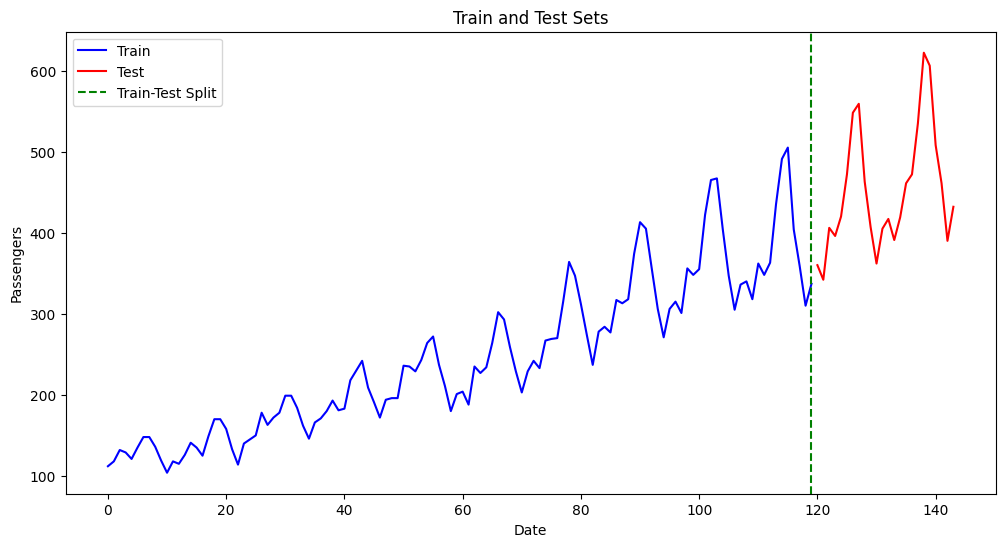

In [421]:
# Plotting train and test sets
plt.figure(figsize=(12, 6))
plt.plot(Train.index, Train['Passengers'], label='Train', color = 'blue')
plt.plot(Test.index, Test['Passengers'], label='Test', color = 'red')
plt.axvline(x=Train.index[-1], color='green', linestyle='--', label='Train-Test Split')
plt.title('Train and Test Sets')
plt.title('Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## Building Equation based Forecasting Models

### 1. Linear model

In [422]:
import numpy as np
linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear = pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
print('Linear Model RMSE:',rmse_linear)

Linear Model RMSE: 74.78775885644497


In [423]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     599.6
Date:                Thu, 02 May 2024   Prob (F-statistic):           4.44e-48
Time:                        08:05:26   Log-Likelihood:                -607.85
No. Observations:                 120   AIC:                             1220.
Df Residuals:                     118   BIC:                             1225.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     94.9661      7.103     13.370      0.000      80.900     109.032
t              2.4949      0.102     24.487      0.000       2.293       2.697
==============================================================================
Omnibus:                       17.280   Durbin-Watson:                   0.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.930
Skew:                           0.833   Prob(JB):                     2.85e-05
Kurtosis:                       4.187   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

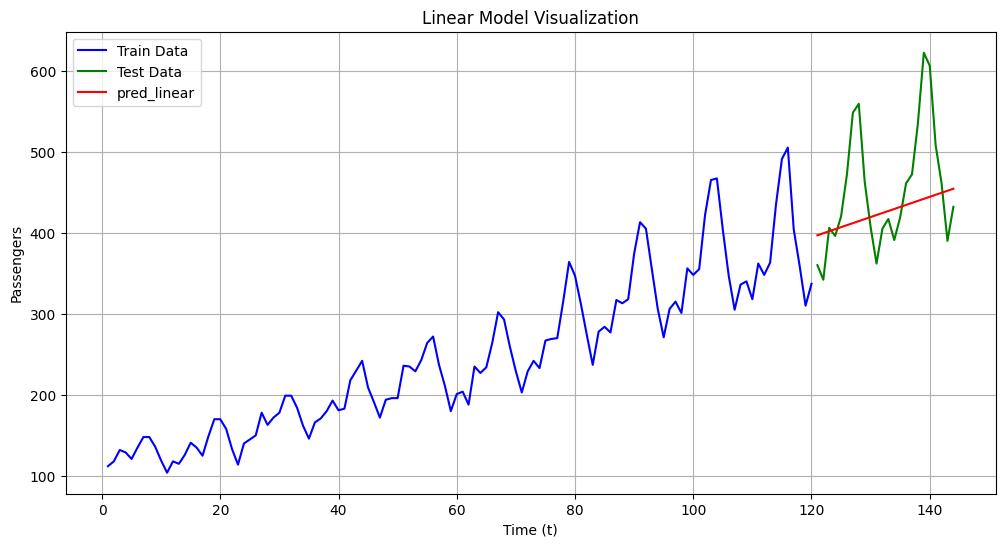

In [424]:
# Visualization
plt.figure(figsize=(12, 6))

# Plot actual train and test data
plt.plot(Train['t'], Train['Passengers'], label='Train Data', color='blue')
plt.plot(Test['t'], Test['Passengers'], label='Test Data', color='green')

# Plot predicted values
plt.plot(Test['t'], pred_linear, label='pred_linear', color='red')

plt.title('Linear Model Visualization')
plt.xlabel('Time (t)')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

### 2. Exponential model

In [425]:
Exp = smf.ols('log_passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
print('Exponential Model RMSE :',rmse_Exp)

Exponential Model RMSE : 79.20071462464722


In [426]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     888.9
Date:                Thu, 02 May 2024   Prob (F-statistic):           9.06e-57
Time:                        08:05:26   Log-Likelihood:                 71.336
No. Observations:                 120   AIC:                            -138.7
Df Residuals:                     118   BIC:                            -133.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7902      0.025    193.624      0.000       4.741       4.839
t              0.0106      0.000     29.814      0.000       0.010       0.011
==============================================================================
Omnibus:                        2.553   Durbin-Watson:                   0.618
Prob(Omnibus):                  0.279   Jarque-Bera (JB):                1.755
Skew:                           0.060   Prob(JB):                        0.416
Kurtosis:                       2.420   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

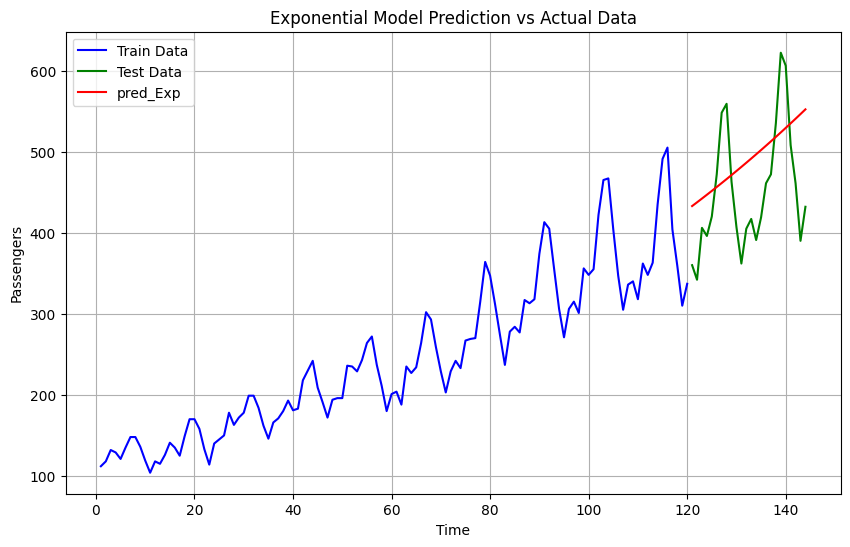

In [427]:
# Creating visualization
plt.figure(figsize=(10, 6))

# Plotting train and test data
plt.plot(Train['t'], Train['Passengers'], label='Train Data', color='blue')
plt.plot(Test['t'], Test['Passengers'], label='Test Data', color='green')

# Plotting predicted values from exponential model
plt.plot(Test['t'], np.exp(pred_Exp), label='pred_Exp', color='red')

plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Exponential Model Prediction vs Actual Data')
plt.legend()
plt.grid(True)
plt.show()

### 3. Quadratic Model

In [428]:
Quad = smf.ols('Passengers~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
print('Quadratic RMSE :',rmse_Quad)

Quadratic RMSE : 69.12811109993947


In [429]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     311.4
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.40e-47
Time:                        08:05:27   Log-Likelihood:                -605.51
No. Observations:                 120   AIC:                             1217.
Df Residuals:                     117   BIC:                             1225.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    112.1385     10.605     10.574      0.000      91.136     133.141
t              1.6504      0.405      4.079      0.000       0.849       2.452
t_square       0.0070      0.003      2.155      0.033       0.001       0.013
==============================================================================
Omnibus:                       12.921   Durbin-Watson:                   0.577
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.520
Skew:                           0.681   Prob(JB):                     0.000703
Kurtosis:                       4.023   Cond. No.                     1.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

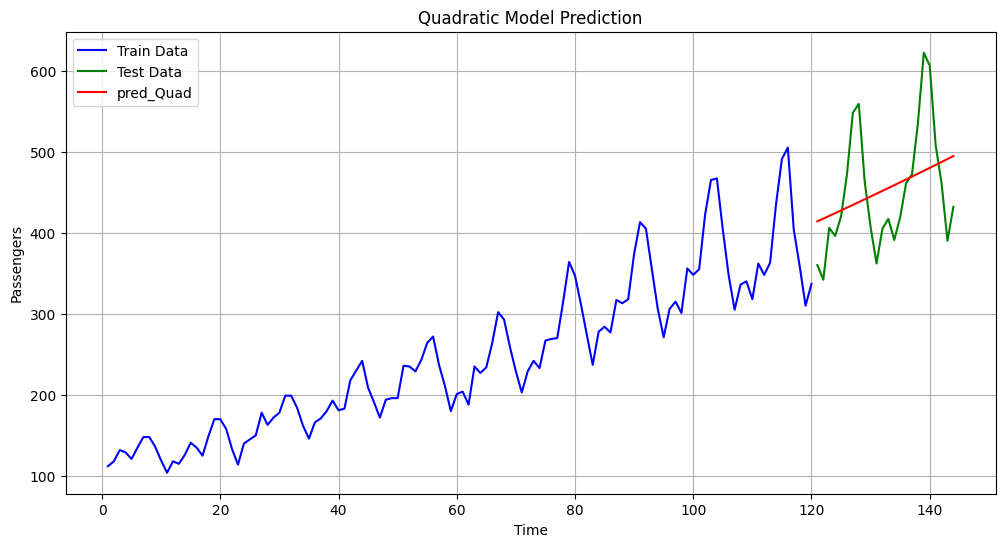

In [430]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting Train and test data
plt.plot(Train['t'], Train['Passengers'], label='Train Data', color = 'blue')
plt.plot(Test['t'], Test['Passengers'], label='Test Data', color = 'green')

# Plotting predicted values for test data
plt.plot(Test['t'], pred_Quad, label='pred_Quad', color='red')

plt.title('Quadratic Model Prediction')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

### 4. Additive seasonality

In [431]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
print('Additive Seasonality RMSE : ',rmse_add_sea)

Additive Seasonality RMSE :  211.38846744008194


In [432]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.345
Date:                Thu, 02 May 2024   Prob (F-statistic):              0.210
Time:                        08:05:27   Log-Likelihood:                -708.46
No. Observations:                 120   AIC:                             1441.
Df Residuals:                     108   BIC:                             1474.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    230.5000     29.555      7.799      0.000     171.917     289.083
Jan          -18.1000     41.797     -0.433      0.666    -100.950      64.750
Feb          -21.8000     41.797     -0.522      0.603    -104.650      61.050
Mar           11.2000     41.797      0.268      0.789     -71.650      94.050
Apr            4.3000     41.797      0.103      0.918     -78.550      87.150
May            6.5000     41.797      0.156      0.877     -76.350      89.350
Jun           42.8000     41.797      1.024      0.308     -40.050     125.650
Jul           74.1000     41.797      1.773      0.079      -8.750     156.950
Aug           74.3000     41.797      1.778      0.078      -8.550     157.150
Sep           35.3000     41.797      0.845      0.400     -47.550     118.150
Oct            2.6000     41.797      0.062      0.951     -80.250      85.450
Nov          -26.3000     41.797     -0.629      0.531    -109.150      56.550
==============================================================================
Omnibus:                       20.621   Durbin-Watson:                   0.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.467
Skew:                           0.253   Prob(JB):                       0.0394
Kurtosis:                       1.982   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

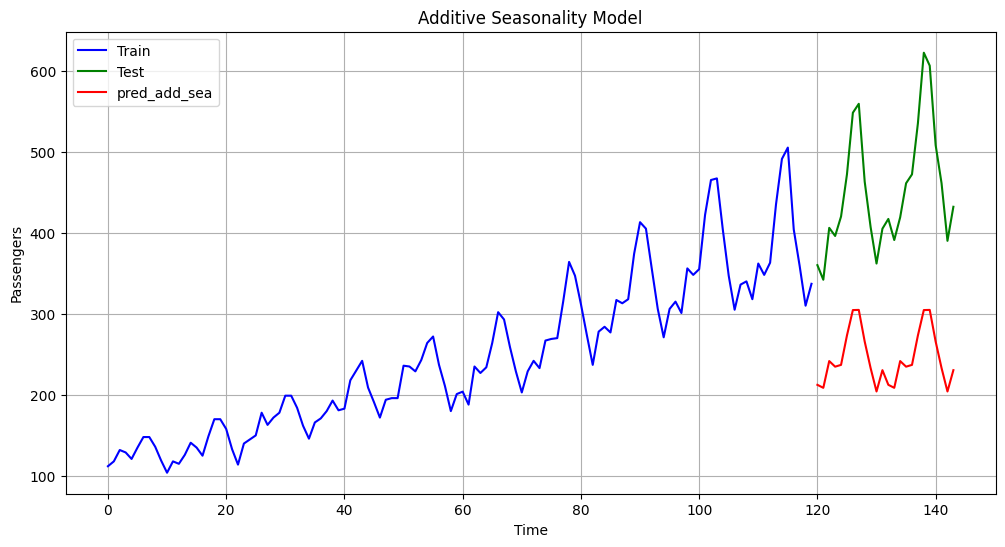

In [433]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot train and test data
plt.plot(Train['Passengers'], label='Train', color='blue')
plt.plot(range(len(Train), len(Train) + len(Test)), Test['Passengers'], label='Test', color='green')

# Plot predicted values
plt.plot(range(len(Train), len(Train) + len(Test)), pred_add_sea, label='pred_add_sea', color='red')

plt.title('Additive Seasonality Model')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

### 5. Additive Seasonality with Quadratic Trend

In [434]:
add_sea_Quad = smf.ols('Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_square']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
print('Additive Seasonality with Quadratic Trend RMSE :',rmse_add_sea_quad)

Additive Seasonality with Quadratic Trend RMSE : 38.62797034235329


In [435]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     194.3
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.37e-67
Time:                        08:05:28   Log-Likelihood:                -523.45
No. Observations:                 120   AIC:                             1075.
Df Residuals:                     106   BIC:                             1114.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     82.9074      8.415      9.853      0.000      66.225      99.590
t              1.6311      0.215      7.601      0.000       1.206       2.057
t_square       0.0072      0.002      4.195      0.000       0.004       0.011
Jan            9.4310      9.048      1.042      0.300      -8.507      27.370
Feb            3.3002      9.045      0.365      0.716     -14.632      21.232
Mar           33.8551      9.042      3.744      0.000      15.929      51.781
Apr           24.4955      9.039      2.710      0.008       6.575      42.416
May           24.2215      9.037      2.680      0.009       6.305      42.138
Jun           58.0331      9.035      6.423      0.000      40.121      75.945
Jul           86.8302      9.033      9.613      0.000      68.922     104.739
Aug           84.5130      9.031      9.358      0.000      66.607     102.419
Sep           42.9814      9.030      4.760      0.000      25.078      60.885
Oct            7.7353      9.030      0.857      0.394     -10.167      25.637
Nov          -23.7251      9.029     -2.628      0.010     -41.626      -5.824
==============================================================================
Omnibus:                        2.119   Durbin-Watson:                   0.525
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                1.584
Skew:                           0.224   Prob(JB):                        0.453
Kurtosis:                       3.341   Cond. No.                     8.14e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

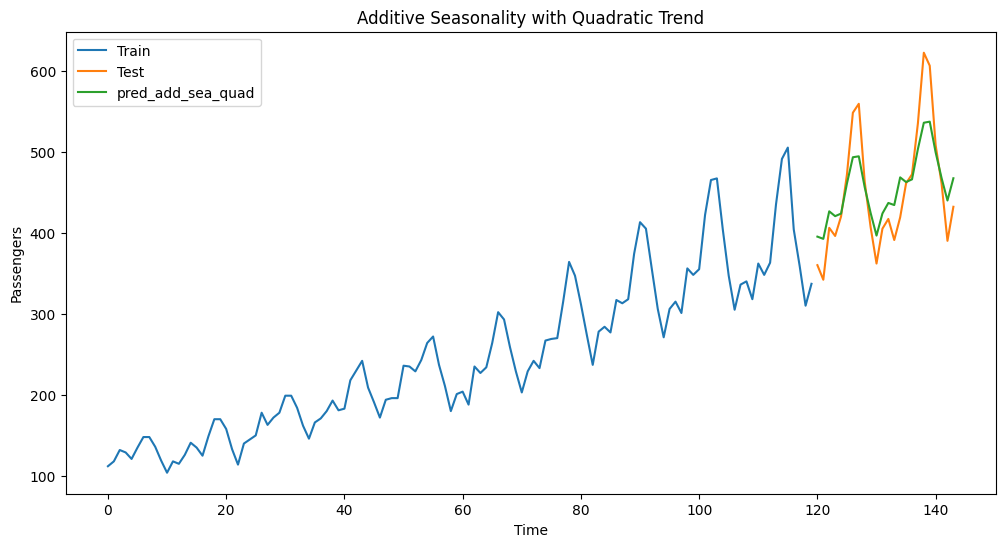

In [436]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(Train['Passengers'], label='Train')
plt.plot(Test.index, Test['Passengers'], label='Test')

# Plot predicted data
plt.plot(Test.index, pred_add_sea_quad, label='pred_add_sea_quad')

plt.title('Additive Seasonality with Quadratic Trend')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

### 6. Multiplicative Seasonality

In [437]:
Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
print('Multiplicative Seasonality RMSE:',rmse_Mult_sea)

Multiplicative Seasonality RMSE: 227.56844750334858


In [438]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.109
Date:                Thu, 02 May 2024   Prob (F-statistic):              0.362
Time:                        08:05:28   Log-Likelihood:                -50.880
No. Observations:                 120   AIC:                             125.8
Df Residuals:                     108   BIC:                             159.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3818      0.123     43.666      0.000       5.137       5.626
Jan           -0.0920      0.174     -0.528      0.599      -0.438       0.253
Feb           -0.0948      0.174     -0.544      0.588      -0.440       0.251
Mar            0.0495      0.174      0.284      0.777      -0.296       0.395
Apr            0.0170      0.174      0.097      0.923      -0.329       0.362
May            0.0180      0.174      0.103      0.918      -0.328       0.363
Jun            0.1524      0.174      0.874      0.384      -0.193       0.498
Jul            0.2592      0.174      1.487      0.140      -0.086       0.605
Aug            0.2608      0.174      1.496      0.138      -0.085       0.606
Sep            0.1358      0.174      0.779      0.438      -0.210       0.481
Oct            0.0047      0.174      0.027      0.979      -0.341       0.350
Nov           -0.1273      0.174     -0.730      0.467      -0.473       0.218
==============================================================================
Omnibus:                       47.461   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.922
Skew:                          -0.169   Prob(JB):                       0.0190
Kurtosis:                       1.788   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

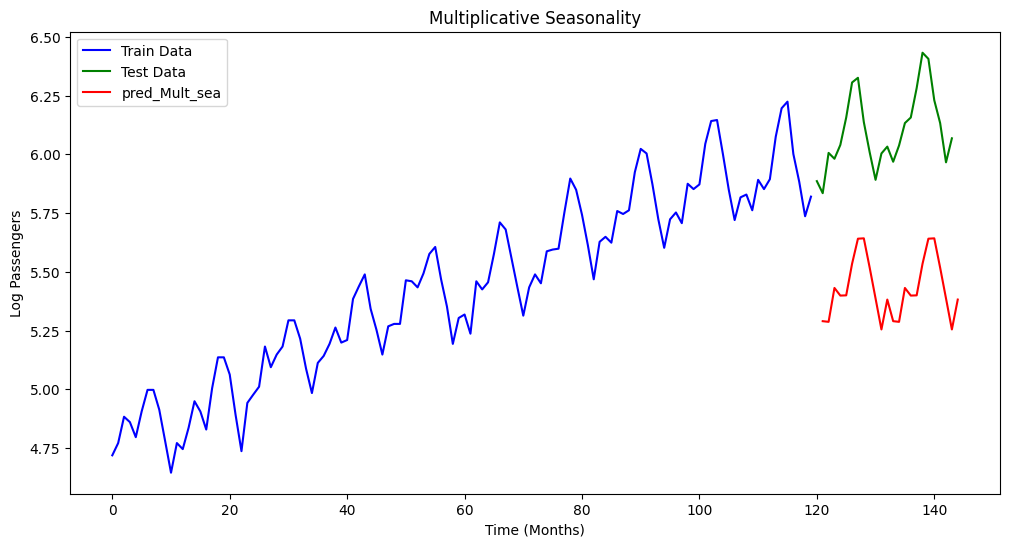

In [439]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting actual train and test data
plt.plot(Train['log_passengers'], label='Train Data', color='blue')
plt.plot(range(len(Train['log_passengers']), len(Train['log_passengers'])+len(Test['log_passengers'])),
         Test['log_passengers'], label='Test Data', color='green')

# Plotting predicted values
plt.plot(range(len(Train['log_passengers'])+1, len(Train['log_passengers'])+len(Test['log_passengers'])+1),
         pred_Mult_sea, label='pred_Mult_sea', color='red')

plt.xlabel('Time (Months)')
plt.ylabel('Log Passengers')
plt.title('Multiplicative Seasonality')
plt.legend()
plt.show()

### 7. Multiplicative Additive Seasonality

In [440]:
Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print('Multiplicative Additive Seasonality RMSE :',rmse_Mult_add_sea)

Multiplicative Additive Seasonality RMSE : 46.87036076533804


In [441]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     498.2
Date:                Thu, 02 May 2024   Prob (F-statistic):           5.70e-88
Time:                        08:05:28   Log-Likelihood:                 185.15
No. Observations:                 120   AIC:                            -344.3
Df Residuals:                     107   BIC:                            -308.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6807      0.020    236.494      0.000       4.641       4.720
t              0.0106      0.000     73.217      0.000       0.010       0.011
Jan            0.0248      0.025      1.012      0.314      -0.024       0.073
Feb            0.0114      0.025      0.464      0.643      -0.037       0.060
Mar            0.1451      0.025      5.913      0.000       0.096       0.194
Apr            0.1019      0.025      4.156      0.000       0.053       0.151
May            0.0923      0.025      3.765      0.000       0.044       0.141
Jun            0.2161      0.025      8.818      0.000       0.168       0.265
Jul            0.3123      0.025     12.744      0.000       0.264       0.361
Aug            0.3033      0.025     12.376      0.000       0.255       0.352
Sep            0.1676      0.025      6.842      0.000       0.119       0.216
Oct            0.0259      0.024      1.058      0.293      -0.023       0.074
Nov           -0.1166      0.024     -4.762      0.000      -0.165      -0.068
==============================================================================
Omnibus:                        3.463   Durbin-Watson:                   0.476
Prob(Omnibus):                  0.177   Jarque-Bera (JB):                3.283
Skew:                          -0.405   Prob(JB):                        0.194
Kurtosis:                       2.963   Cond. No.                         871.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

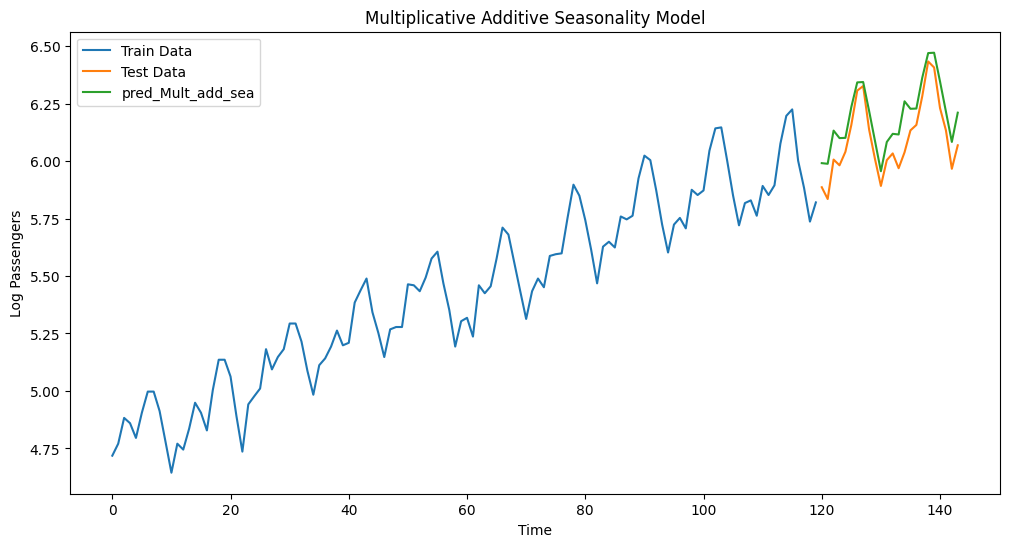

In [442]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))

# Plot actual train and test data
plt.plot(Train['log_passengers'], label='Train Data')
plt.plot(range(len(Train), len(Train) + len(Test)), Test['log_passengers'], label='Test Data')

# Plot predicted values
plt.plot(range(len(Train), len(Train) + len(Test)), pred_Mult_add_sea, label='pred_Mult_add_sea')

plt.title('Multiplicative Additive Seasonality Model')
plt.xlabel('Time')
plt.ylabel('Log Passengers')
plt.legend()
plt.show()

In [443]:
#Compare the results
data2 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
         "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
type(data2)

table_rmse2 = pd.DataFrame(data2)
table_rmse2.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,38.627970
6,rmse_Mult_add_sea,46.870361
2,rmse_Quad,69.128111
0,rmse_linear,74.787759
1,rmse_Exp,79.200715
3,rmse_add_sea,211.388467
5,rmse_Mult_sea,227.568448


### RMSE table for all the models

In [444]:
table_RMSE = pd.concat([table_rmse1, table_rmse2], ignore_index=True)

# Sorting concatenated DataFrame by RMSE_Values
table_RMSE = table_RMSE.sort_values(by='RMSE_Values')
table_RMSE

,MODEL,RMSE_Values
5,hwe_model_add_add,32.010790
10,rmse_add_sea_quad,38.627970
4,SARIMA,39.434170
12,rmse_Mult_add_sea,46.870361
8,rmse_Quad,69.128111
6,rmse_linear,74.787759
3,hwe_model_mul_add,79.164062
7,rmse_Exp,79.200715
2,ARIMA,83.624728
1,SES,86.968910


## Visualizing Models Performance

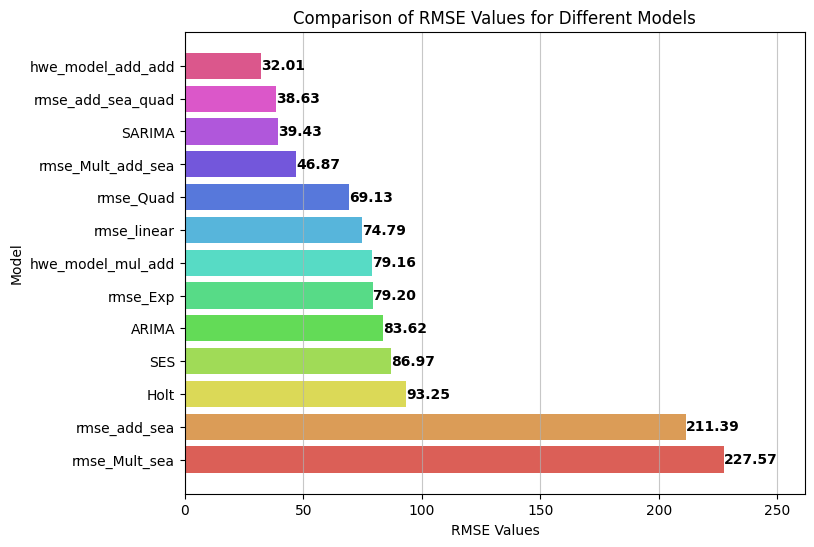

In [445]:
table_RMSE = table_RMSE.sort_values(by='RMSE_Values', ascending=False)

# Create a color palette using seaborn's 'hls' palette
colors = sns.color_palette('hls', len(table_RMSE))

# Create visualization with the 'hls' palette
plt.figure(figsize=(8, 6))
bars = plt.barh(table_RMSE['MODEL'], table_RMSE['RMSE_Values'], color=colors)
plt.xlabel('RMSE Values')
plt.ylabel('Model')
plt.title('Comparison of RMSE Values for Different Models')
plt.grid(axis='x', linestyle='-', alpha=0.7)

# Add RMSE values next to the bars
for bar, value in zip(bars, table_RMSE['RMSE_Values']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center', fontweight='bold')

# Adjust x-axis limits to accommodate annotations
plt.xlim(0, max(table_RMSE['RMSE_Values']) * 1.15)
plt.show()

## **Holt's Double Exponential Smoothing** has the lowest RMSE, making it our best model so far.